In [2]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Attaching sp

Loading required package: Rcpp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introd

In [97]:
rep_1 <- here(data_path,"zm.Leaf_rep1.QC_v2_QC_soc_obj.rds")
rep_2 <- here(data_path,"zm.Leaf_rep2.QC_v2_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [98]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3 x values <= 0 omitted from logarithmic plot"


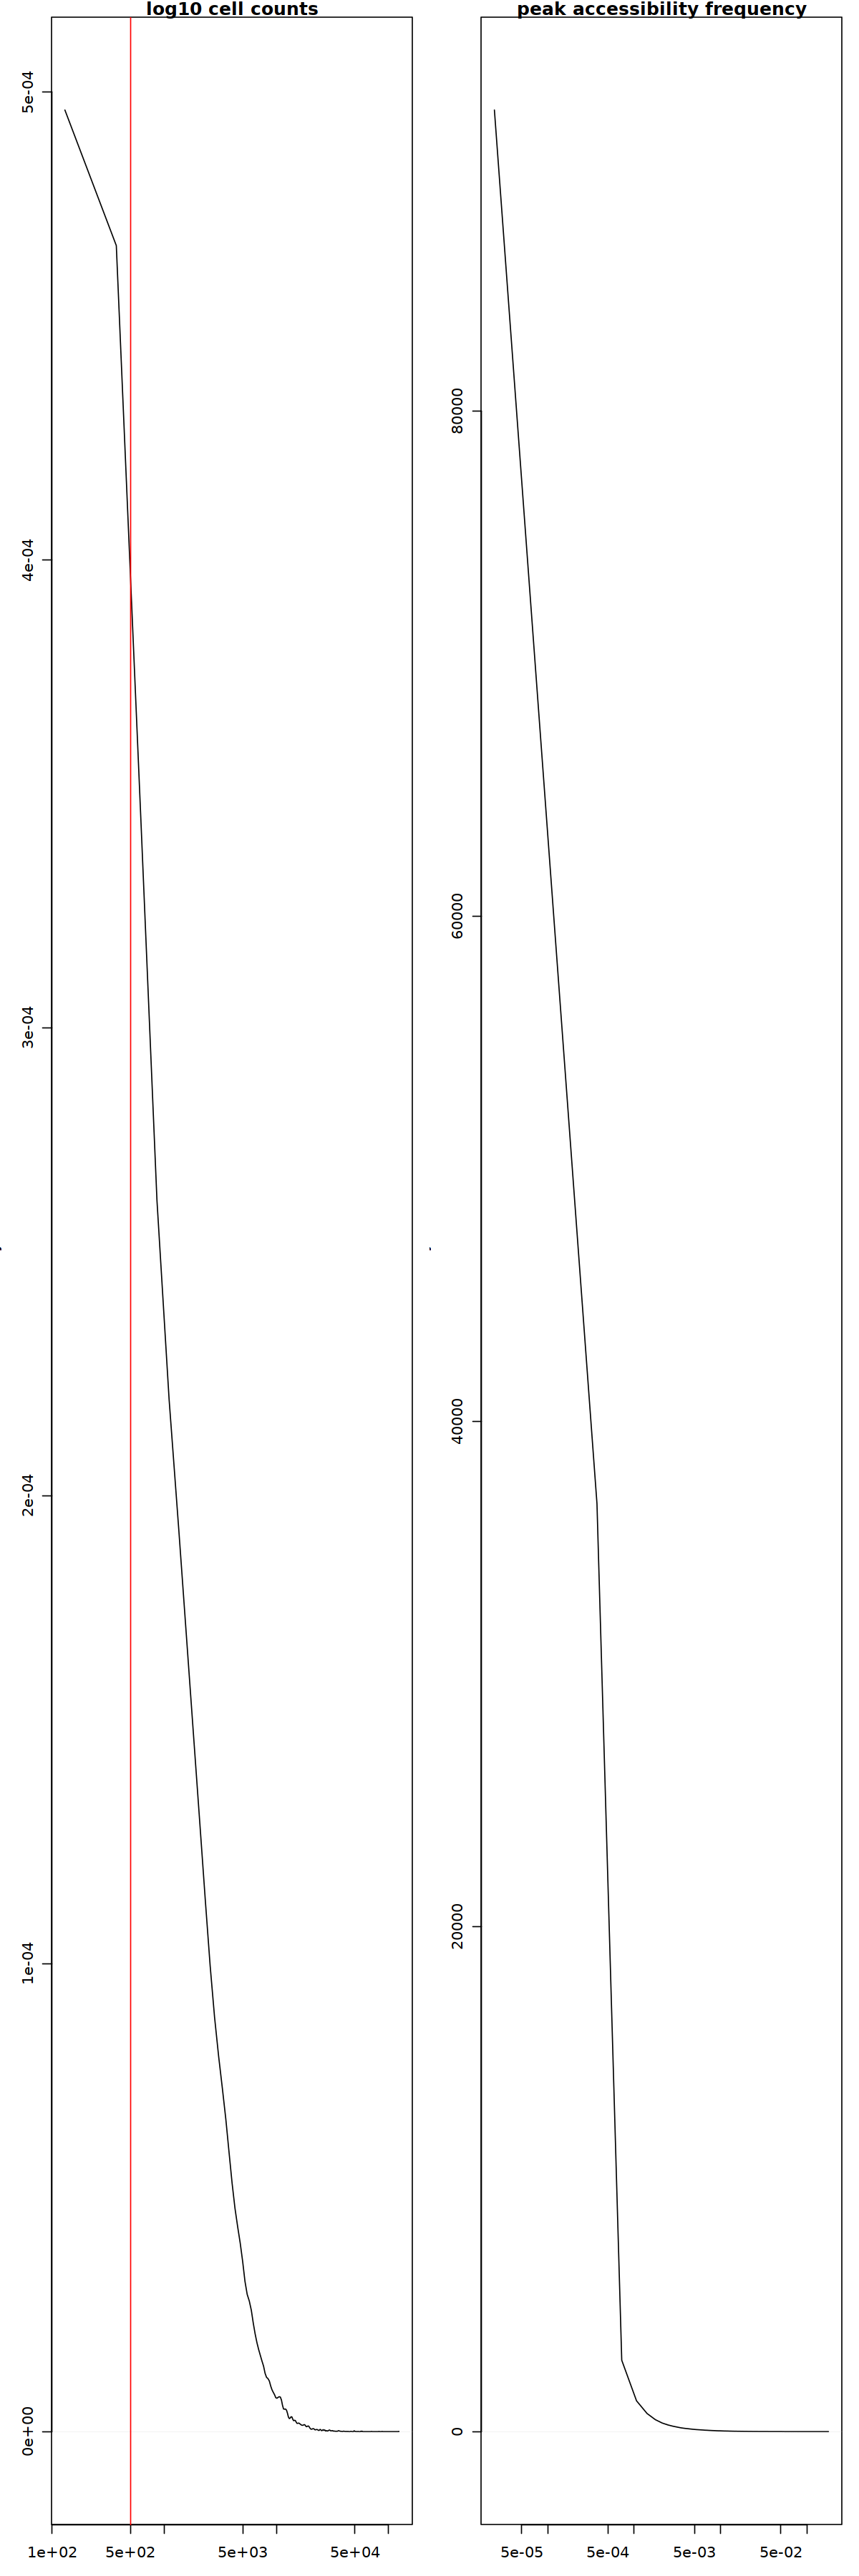

In [99]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [100]:
dim(soc.obj$meta)

[1] 30556    18

In [101]:
?projectUMAP

ℹ Rendering development documentation for "projectUMAP"


In [102]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)

In [103]:
# clean sparse counts matrix ---------------------------------------------
soc.obj.clean <- cleanData(soc.obj, 
                     min.c=50,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.01, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 30556 | peaks = 6645691

   * Filtered: cells = 23662 | peaks = 70487



In [104]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj.clean)

In [105]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=50, 
                      cor.max = .5,
                      num.var=NULL,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

16:03:54 UMAP embedding parameters a = 1.896 b = 0.8006

16:03:54 Read 23662 rows and found 49 numeric columns

16:03:54 Using Annoy for neighbor search, n_neighbors = 25

16:03:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:03:57 Writing NN index file to temp file /tmp/RtmpiFHVgo/file3afd52f9b5363

16:03:57 Searching Annoy index using 16 threads, search_k = 2500

16:03:57 Annoy recall = 100%

16:04:06 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 25

16:04:10 Initializing from normalized Laplacian + noise (using irlba)

16:04:10 Commencing optimization for 200 epochs, with 964660 positive edges

16:04:51 Optimization finished



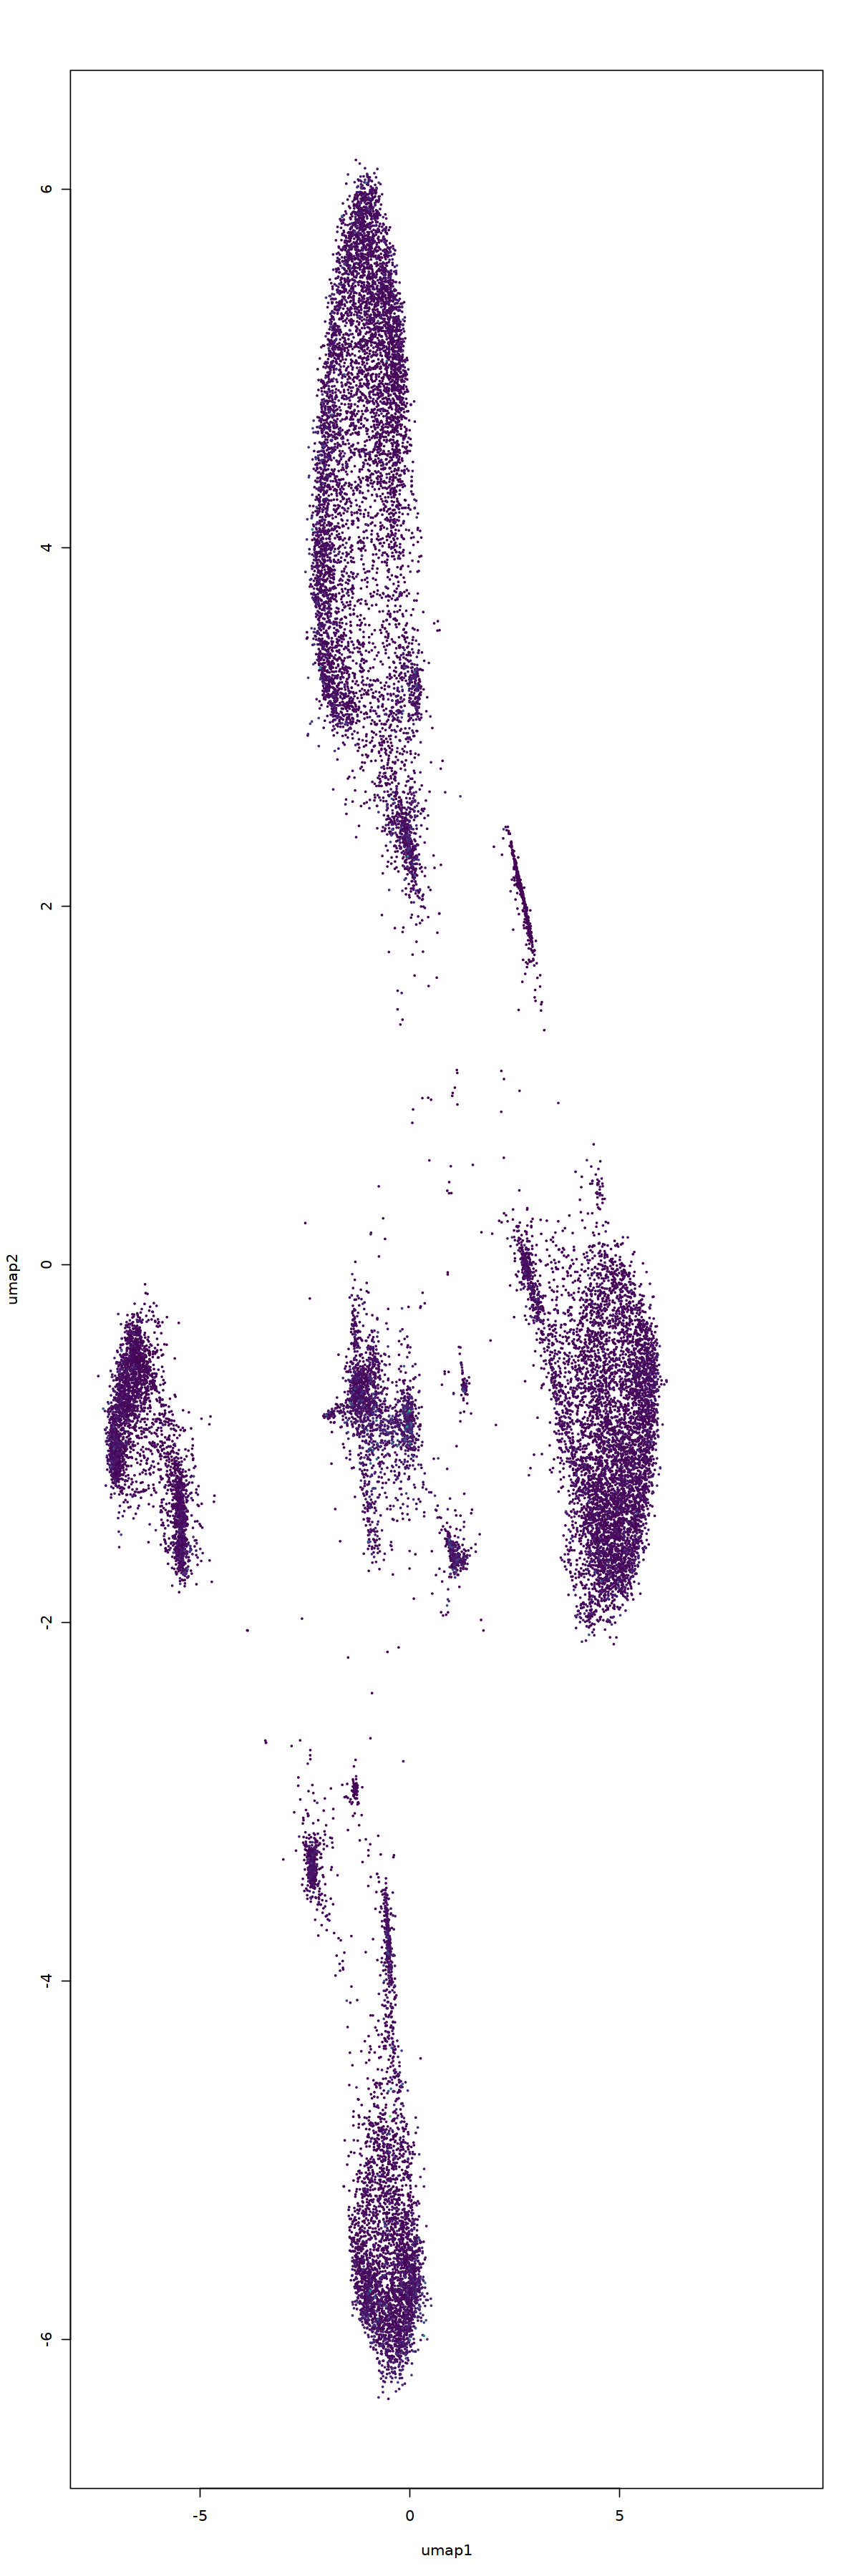

In [106]:
plotUMAP(soc.obj.project_umap, cex=0.3, column = "total")

In [107]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

Warning message in mclapply(seq_len(nTrials), function(y) {:
"scheduled cores 4, 9 did not deliver results, all values of the jobs will be affected"
 - Created 92000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [108]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [109]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [110]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

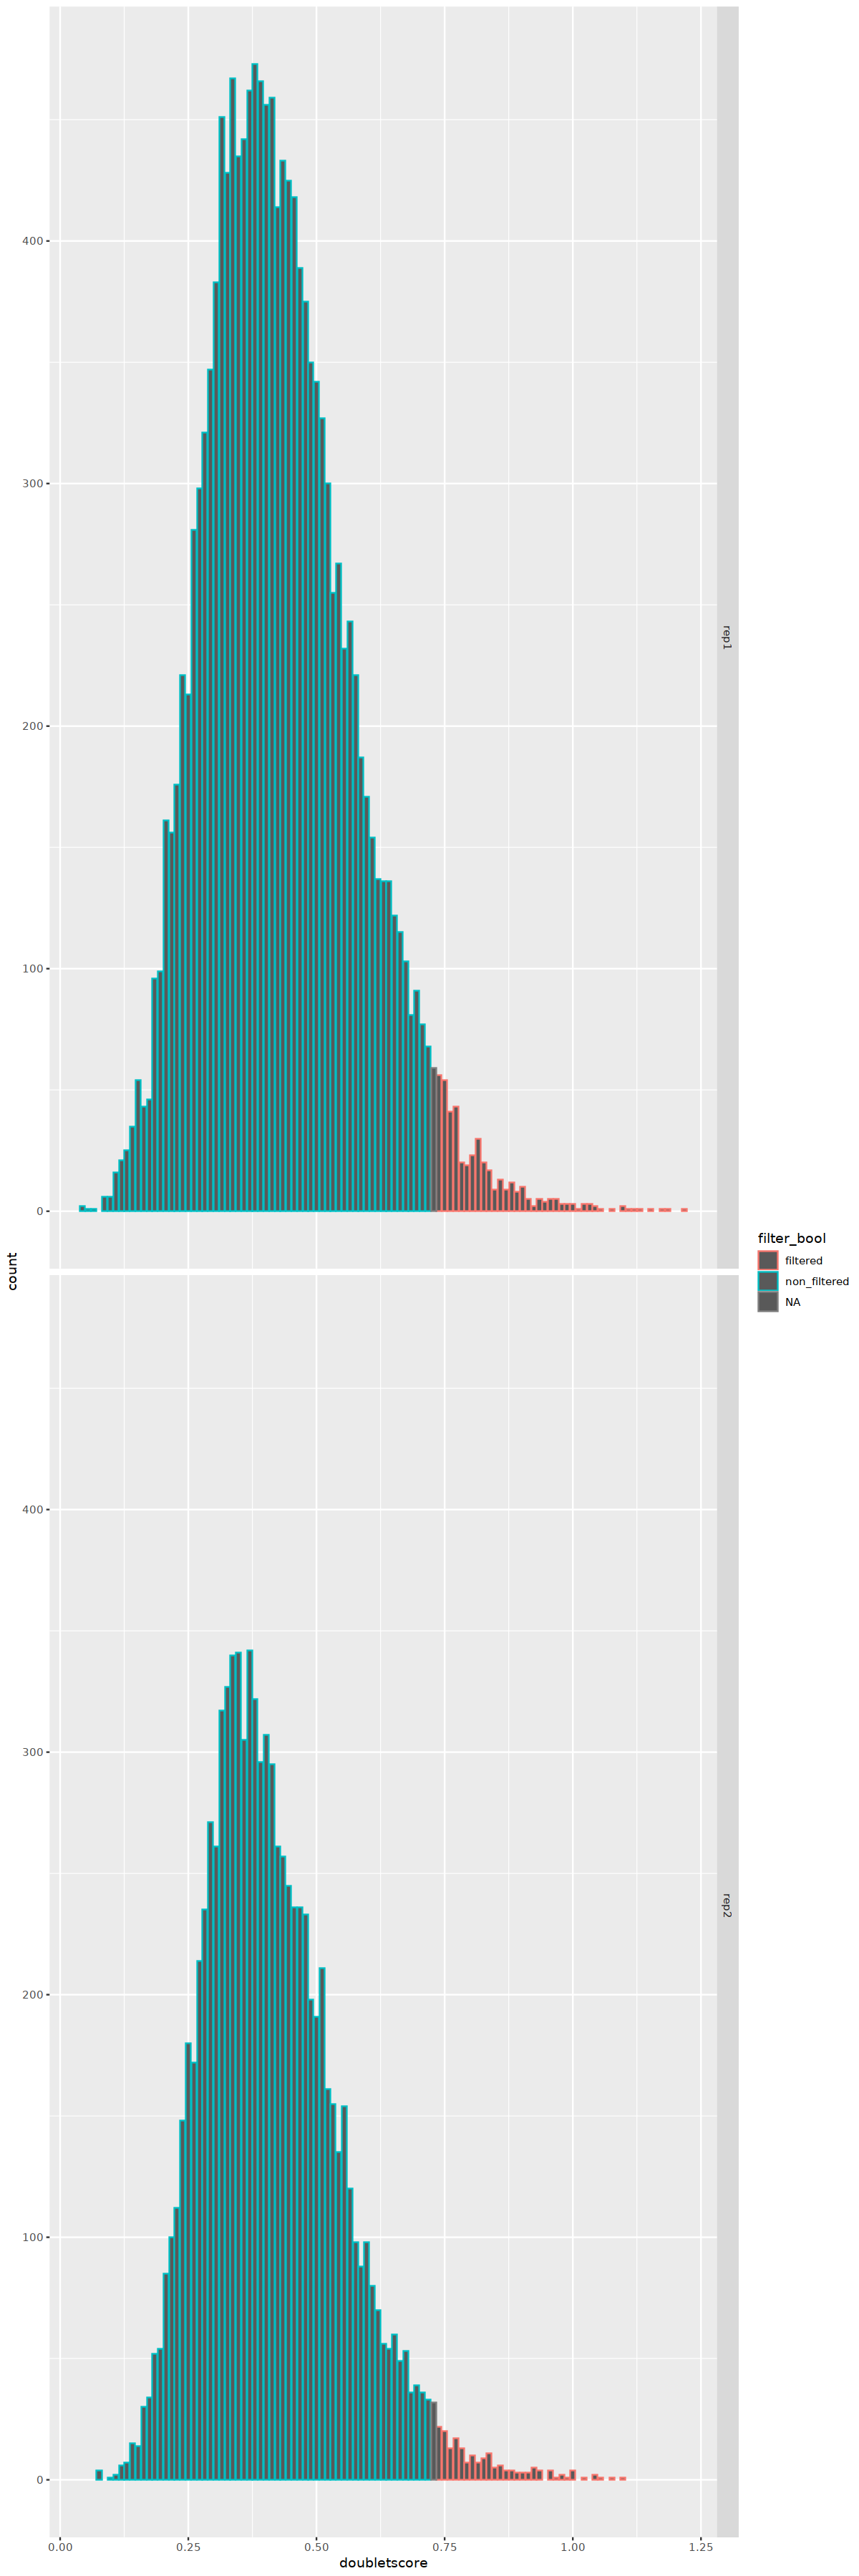

In [111]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore > remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

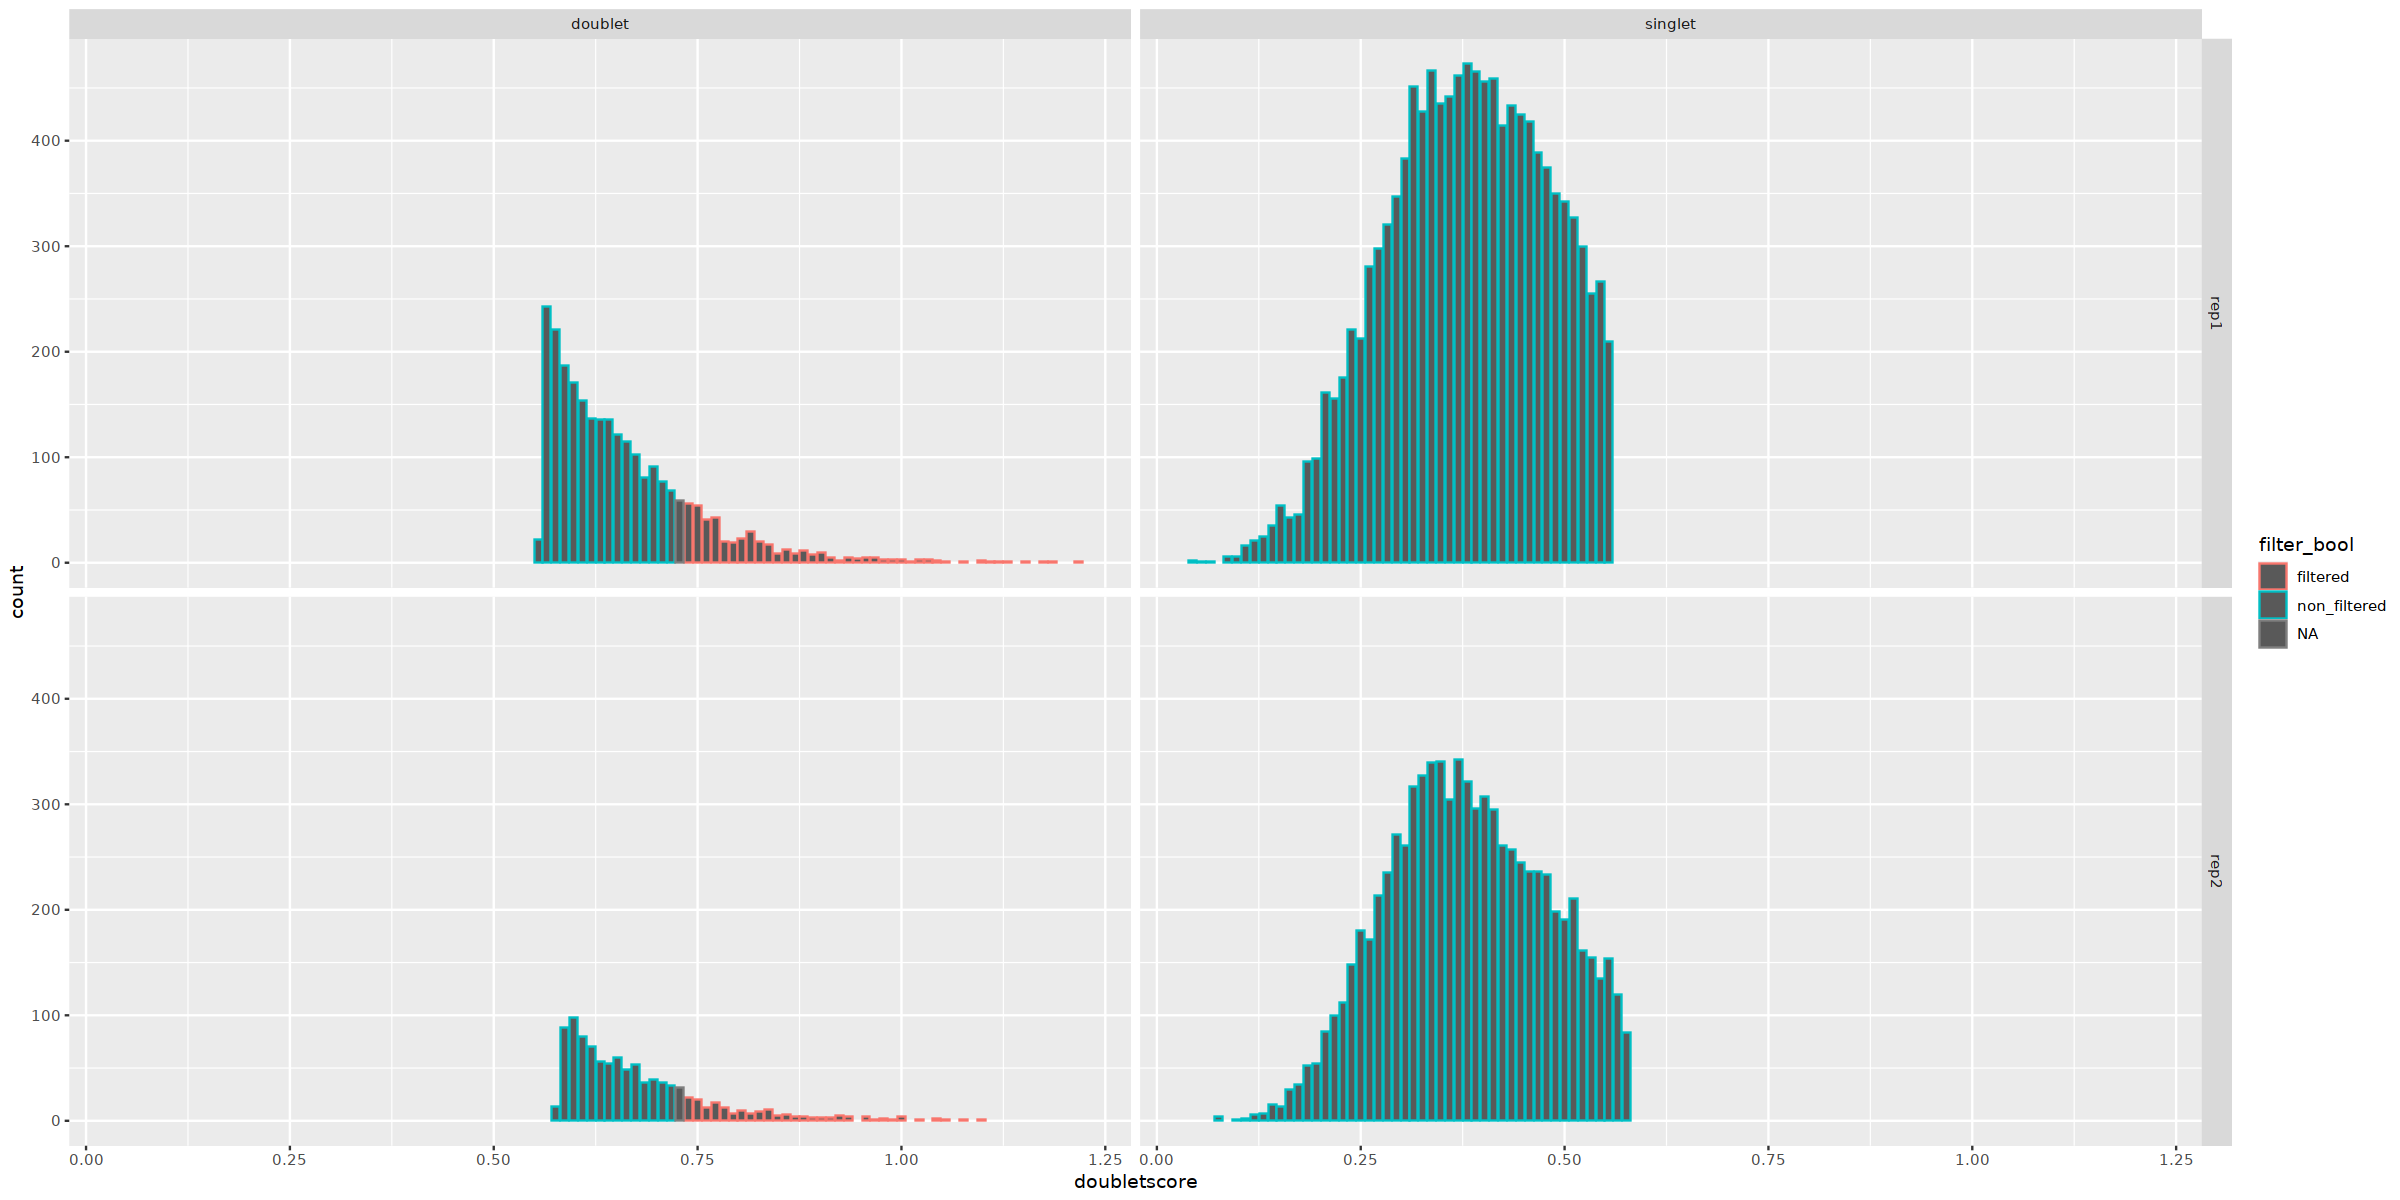

In [117]:
options(repr.plot.width=20, repr.plot.height=10)
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore > remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~d.type)

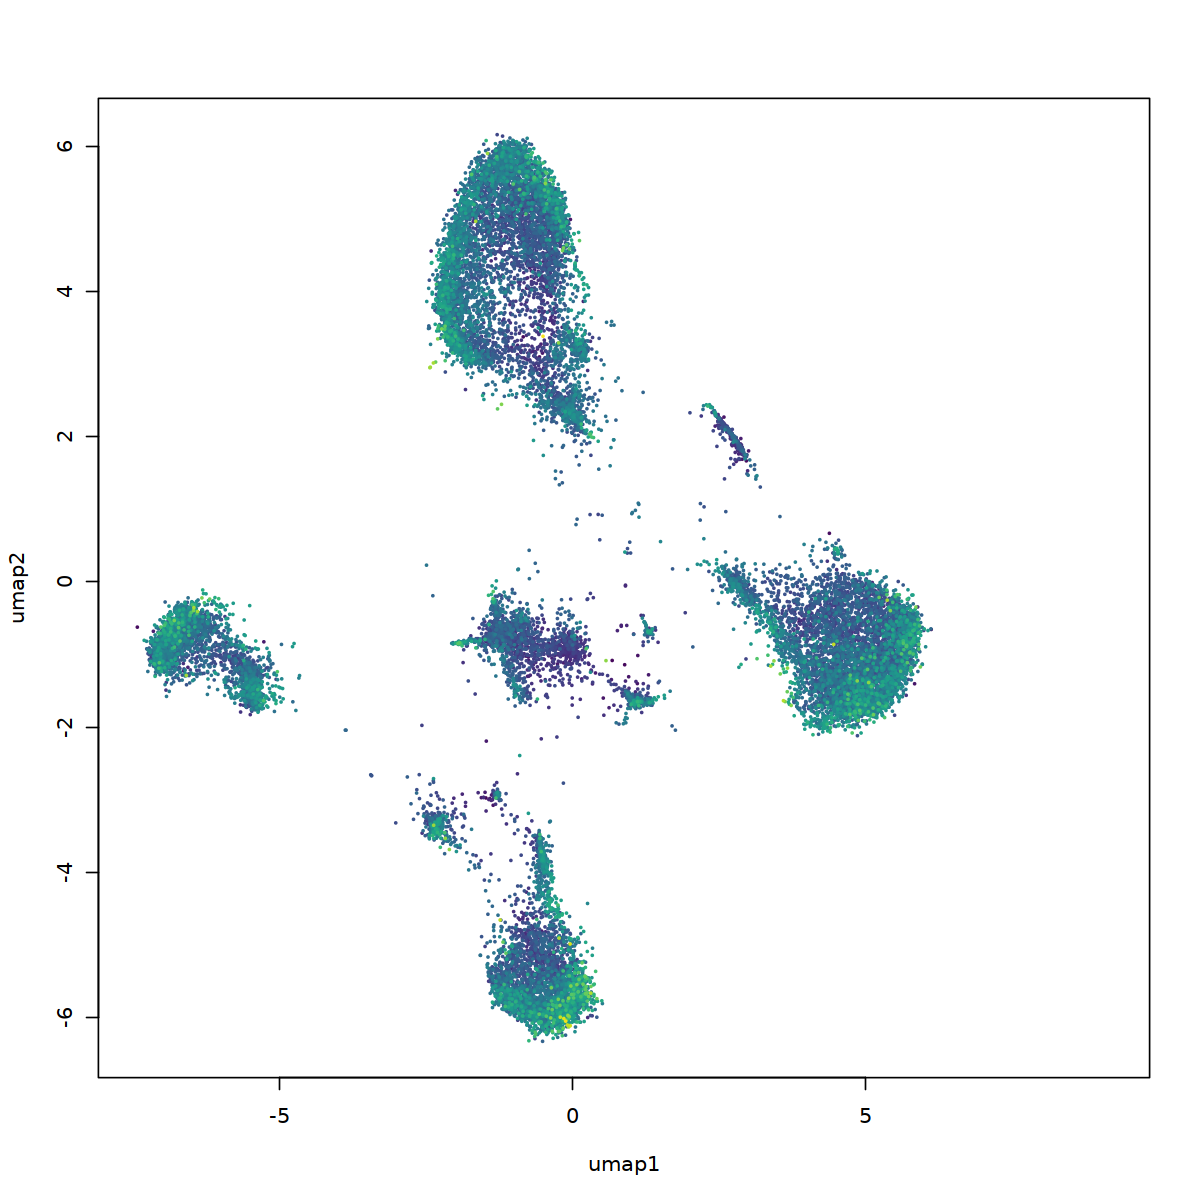

In [116]:
options(repr.plot.width=10, repr.plot.height=10)
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "doubletscore")

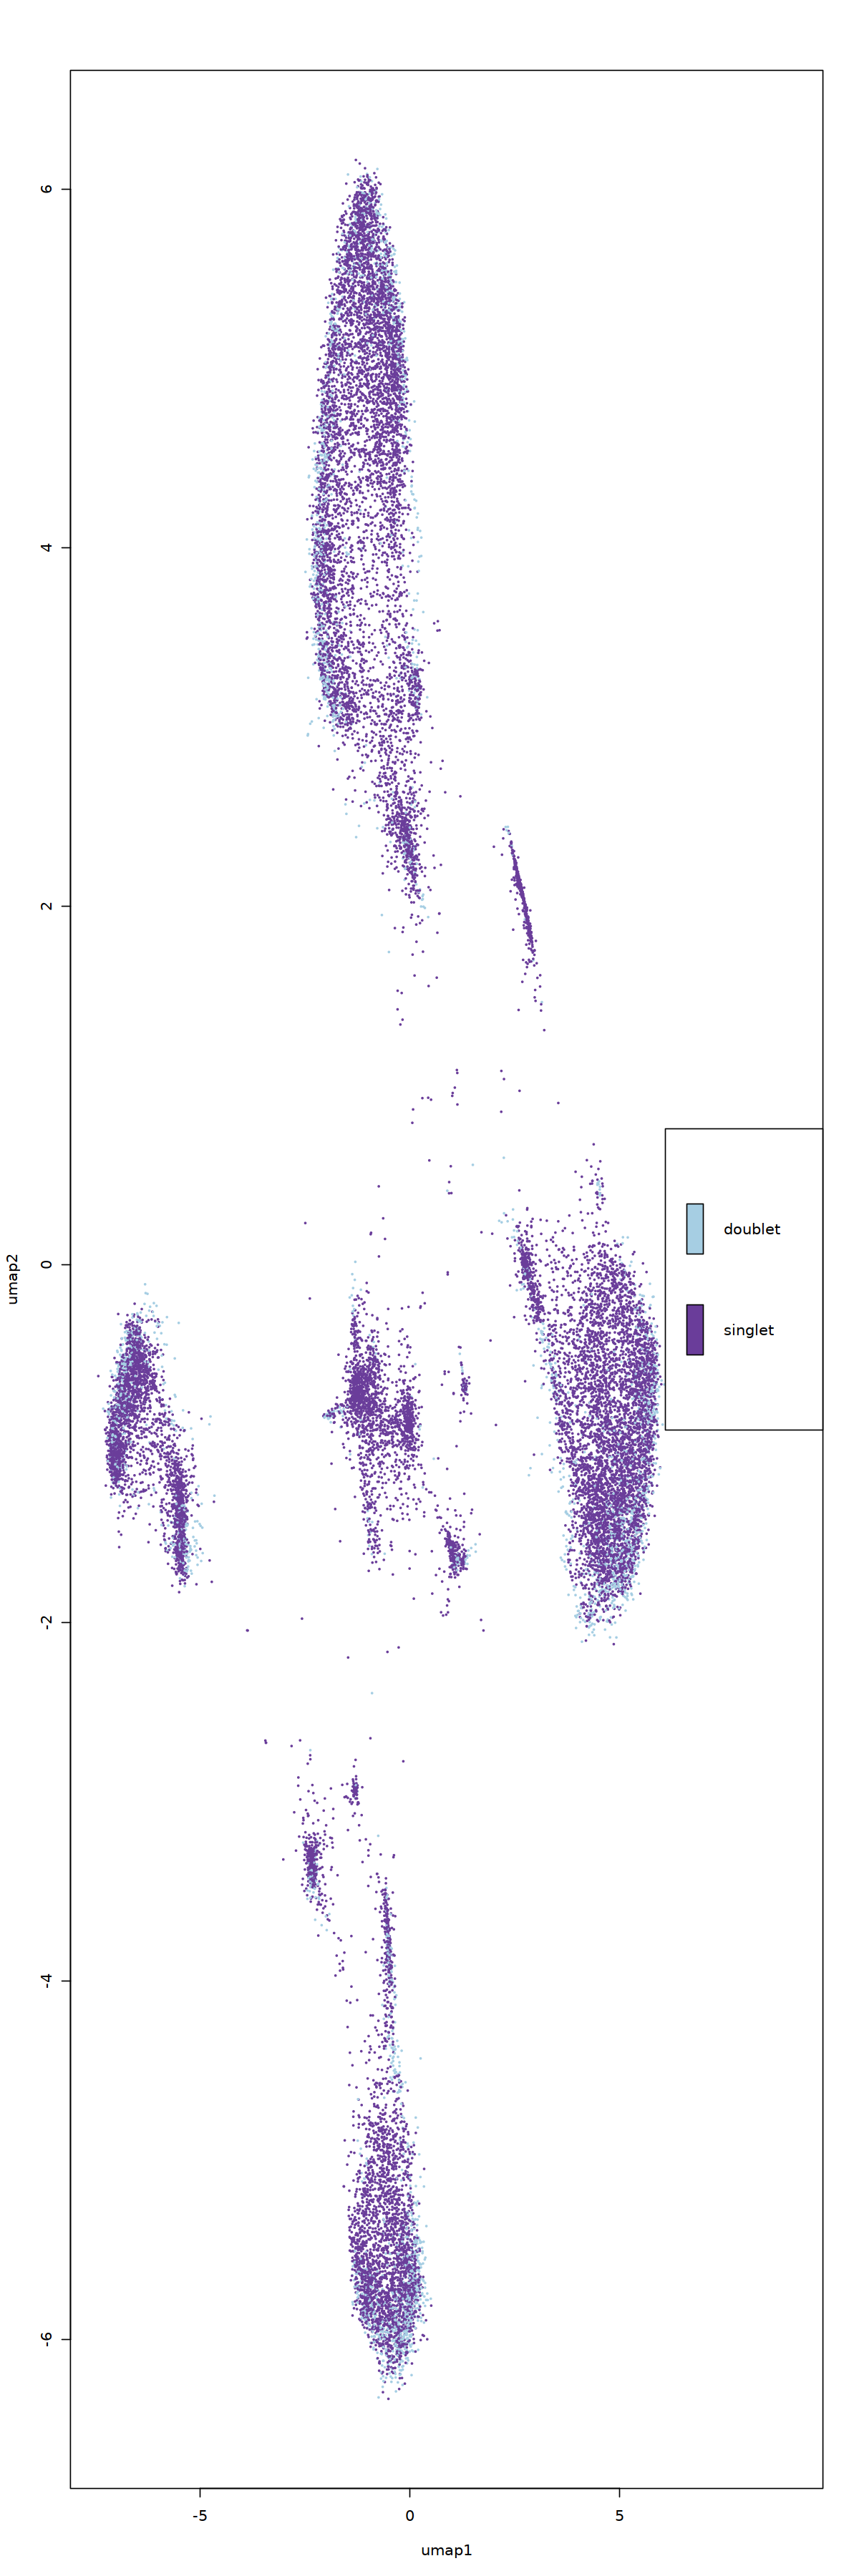

In [114]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [120]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

remove_doublets <- function(obj) { 
    
    old_meta <- obj$meta

    new_meta <- subset(old_meta, d.type == "singlet") 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

filter_ptmt_ratio <- function(obj, ratio) { 
    
    old_meta <- obj$meta
    old_meta$ptmt_ratio <- old_meta$ptmt/old_meta$total
    

    new_meta <- subset(old_meta, ptmt_ratio < ratio) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.ptmt_filter <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * PtMt filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}


plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [121]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

cellID                                                total  tss   acrs  ptmt
1 BC:Z:GTGAAAGGCTACAAACAATGAGCTCGGA-Zm_rep1_P4_10x.rep1 175951 26318 26888 3467
2 BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1 131016 30764 44240  661
3 BC:Z:GTTTCGATGTCAAGCGAGTCCGCACCGG-Zm_rep1_P6_10x.rep1  81977 11518 13790  308
4 BC:Z:GAGTGGAGTTCCAGCGAGTCCGCACTAA-Zm_rep1_P8_10x.rep1  76035 10459 10258 3856
5 BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1  79374 27656 40709  411
6 BC:Z:GTGAAAATGTCAAGCGAGTTTCGACTAA-Zm_rep1_P4_10x.rep1  69248  3883  1797   45
  nSites log10nSites pTSS       FRiP       pOrg         ⋯ qc_check background 
1 122915 5.089605    0.14957573 0.15281527 0.0197043495 ⋯ 0        0.009191725
2  87503 4.942023    0.23481102 0.33766868 0.0050451853 ⋯ 1        0.006805947
3  56566 4.752555    0.14050282 0.16821791 0.0037571514 ⋯ 0        0.006282299
4  53253 4.726344    0.13755507 0.13491155 0.0507134872 ⋯ 0        0.009905048
5  50972 4.707332    0.34842644 0.51287575 0.0051780180 ⋯ 1        0.004843727
6  49831 4.697500    0.05607382 0.02595021 0.0006498383 ⋯ 0        0.002549059
  cellbulk    is_cell sampleID umap1       umap2      doubletscore d.type 
1 0.086039008 1       rep1     -0.57539534 -0.8122125 0.2826087    singlet
2 0.139869893 1       rep1     -0.46672346 -4.7543831 0.2826087    singlet
3 0.070059701 1       rep1     -0.04450613  2.2794000 0.3369565    singlet
4 0.041046156 1       rep1     -1.42091571 -0.7719665 0.2282609    singlet
5 0.145387869 1       rep1      0.33847077 -5.9794717 0.2717391    singlet
6 0.004249504 1       rep1     -0.05815693 -0.9040868 0.1847826    singlet
  filter_bool 
1 non_filtered
2 non_filtered
3 non_filtered
4 non_filtered
5 non_filtered
6 non_filtered

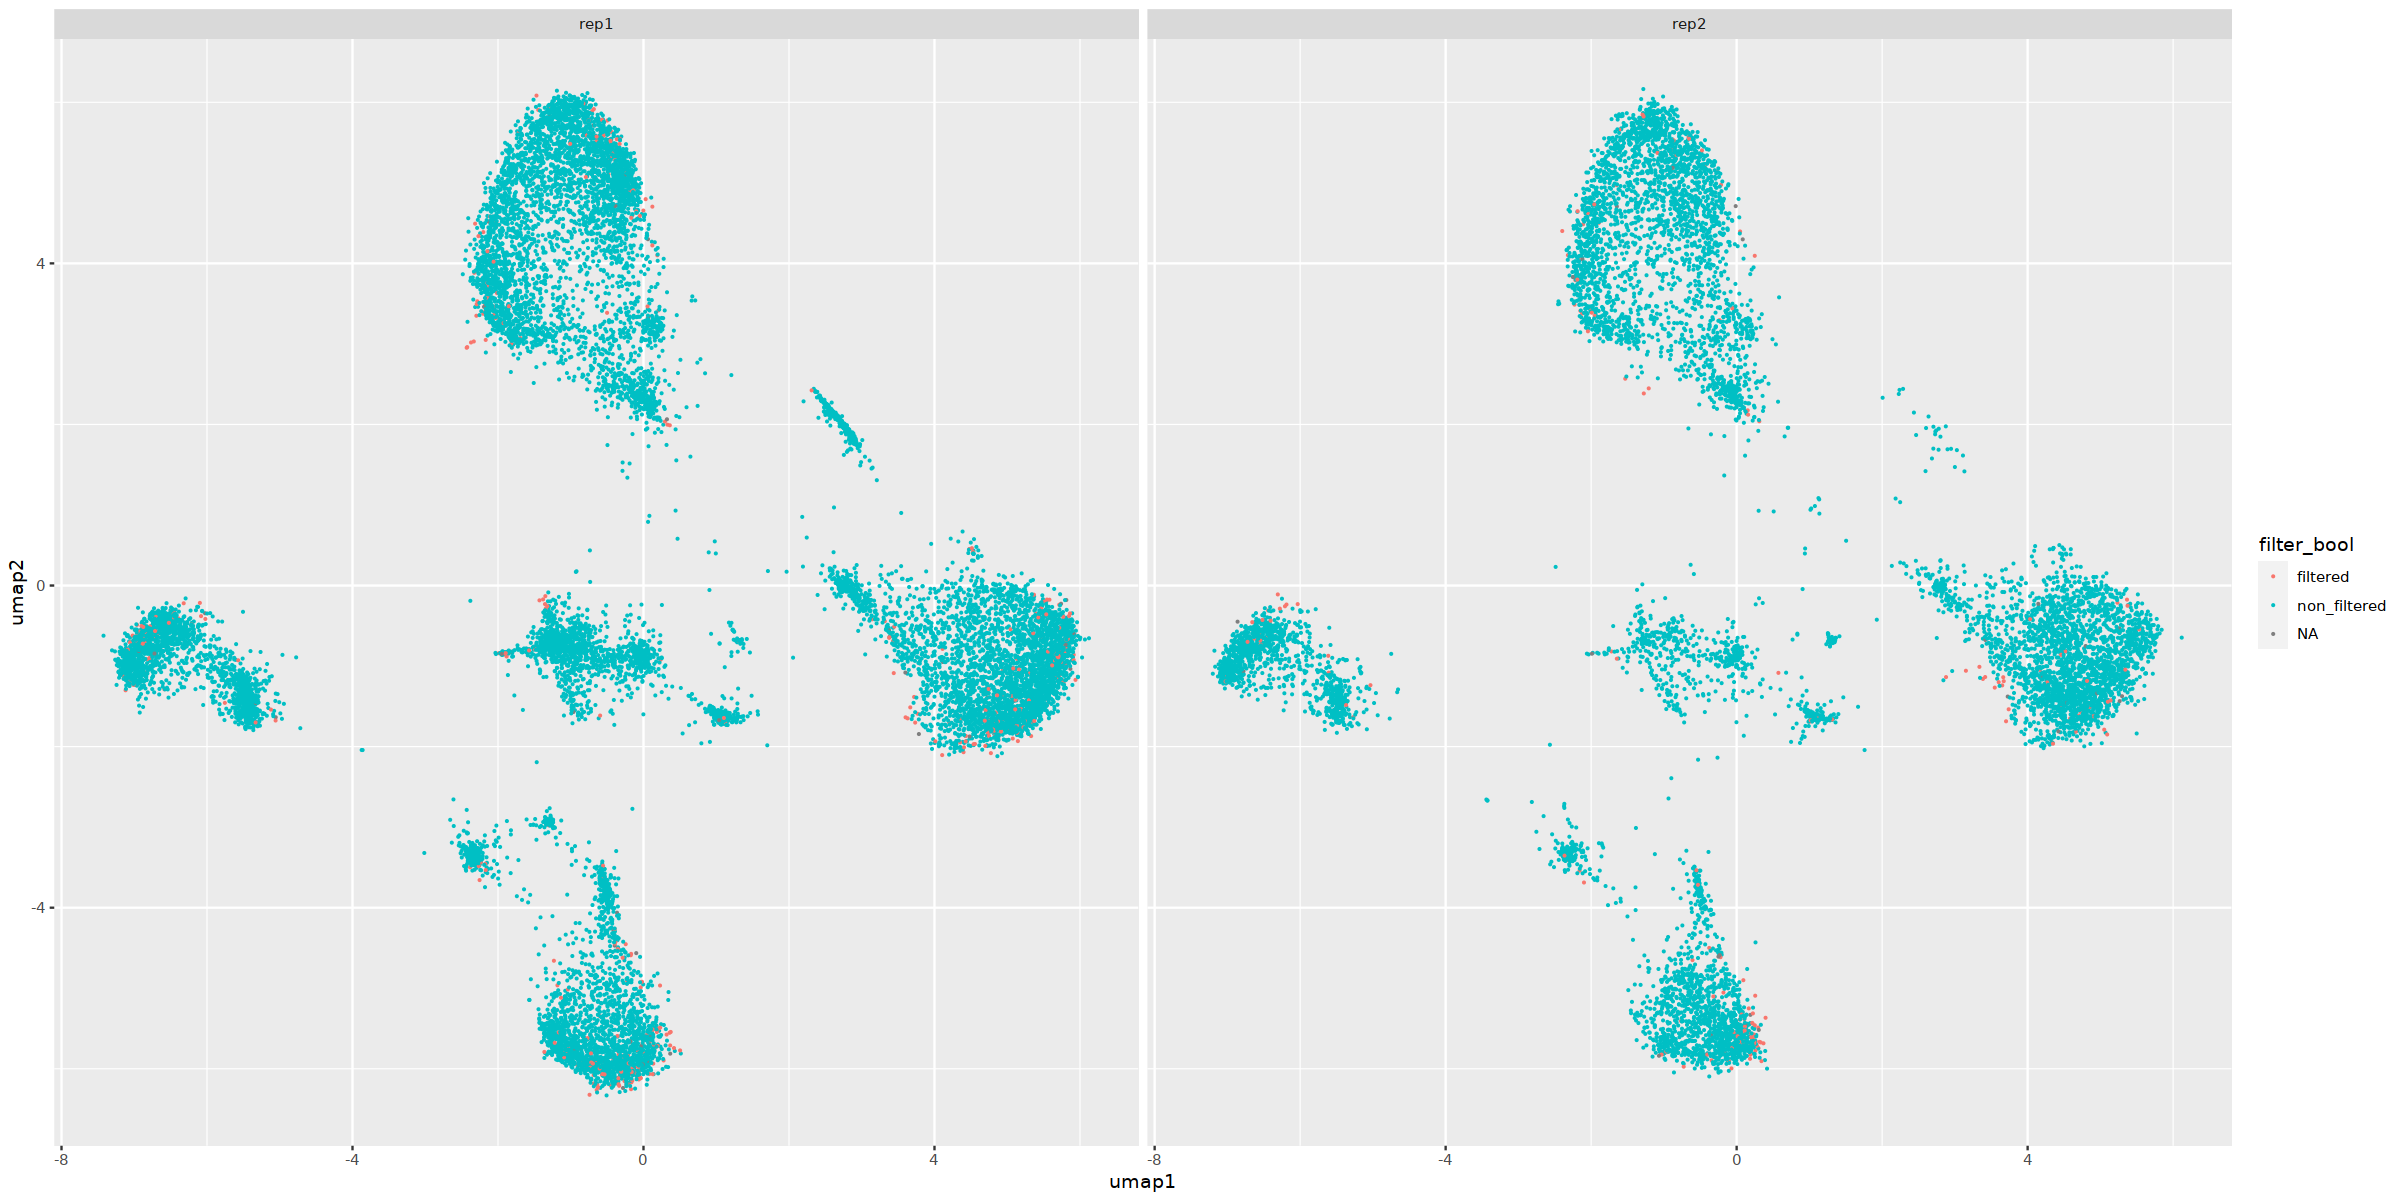

In [122]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

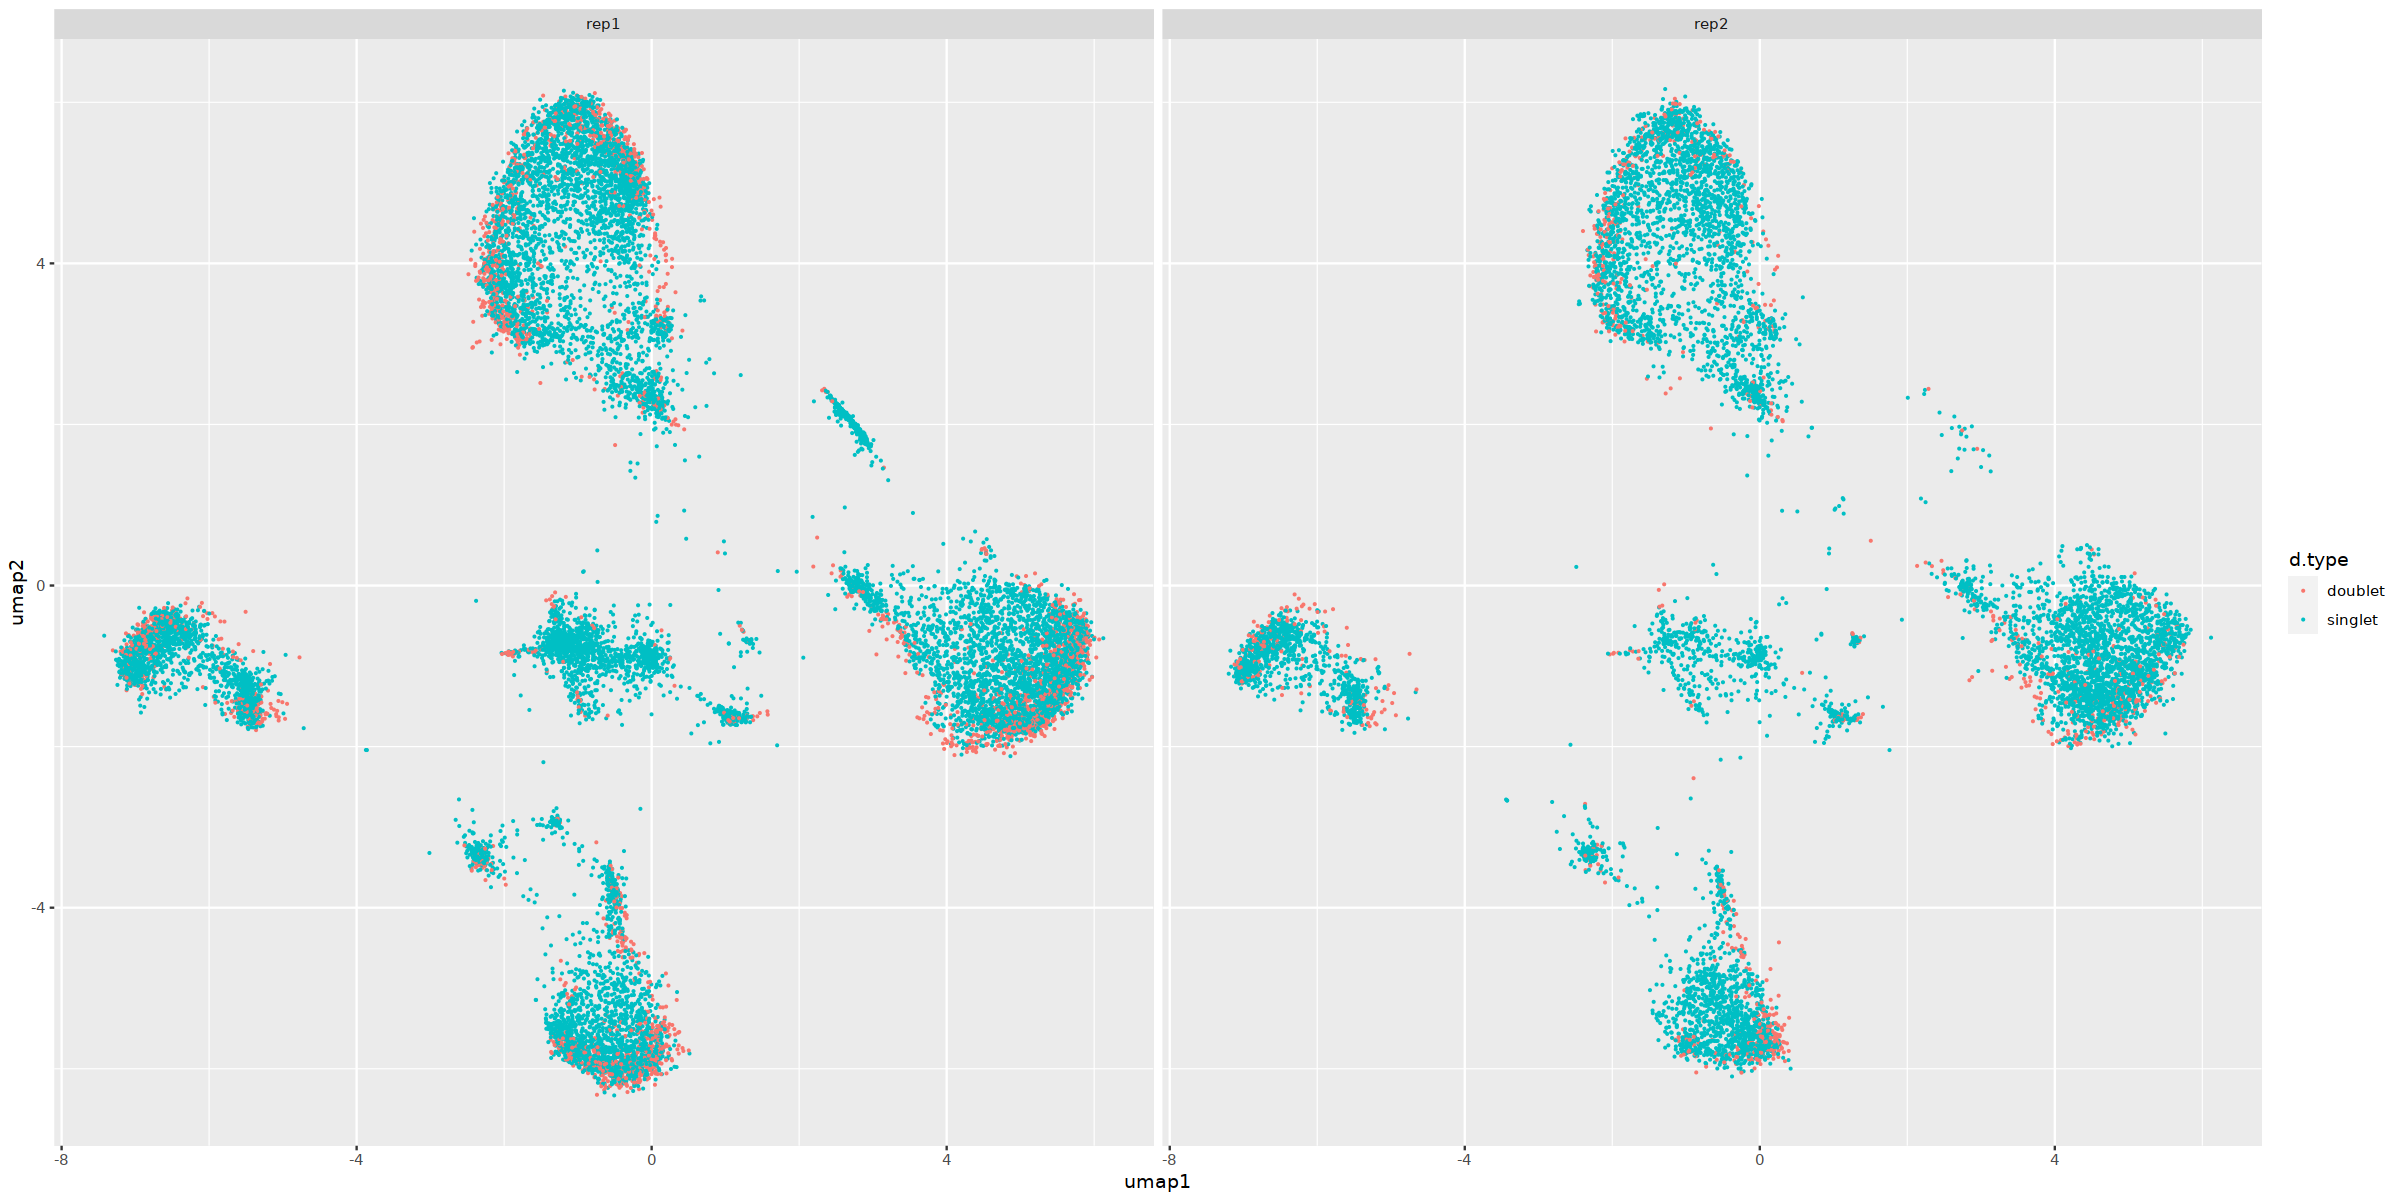

In [123]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = d.type)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [124]:
tfidf.obj.dob.filt.removed <- remove_doublets(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 3544  Filtered: cells = 20118 | peaks = 70487



In [125]:
tfidf.obj.dob.filt.removed <- filter_ptmt_ratio(tfidf.obj.dob.filt.removed, .15)

   * PtMt filtering * Number cells removed= 40  Filtered: cells = 20078 | peaks = 70487



In [142]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2.5,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19802
Number of edges: 1289851

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7175
Number of communities: 87
Elapsed time: 40 seconds


63 singletons identified. 24 final clusters.

 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 19600

 - filtering clusters with low cell/read counts ...



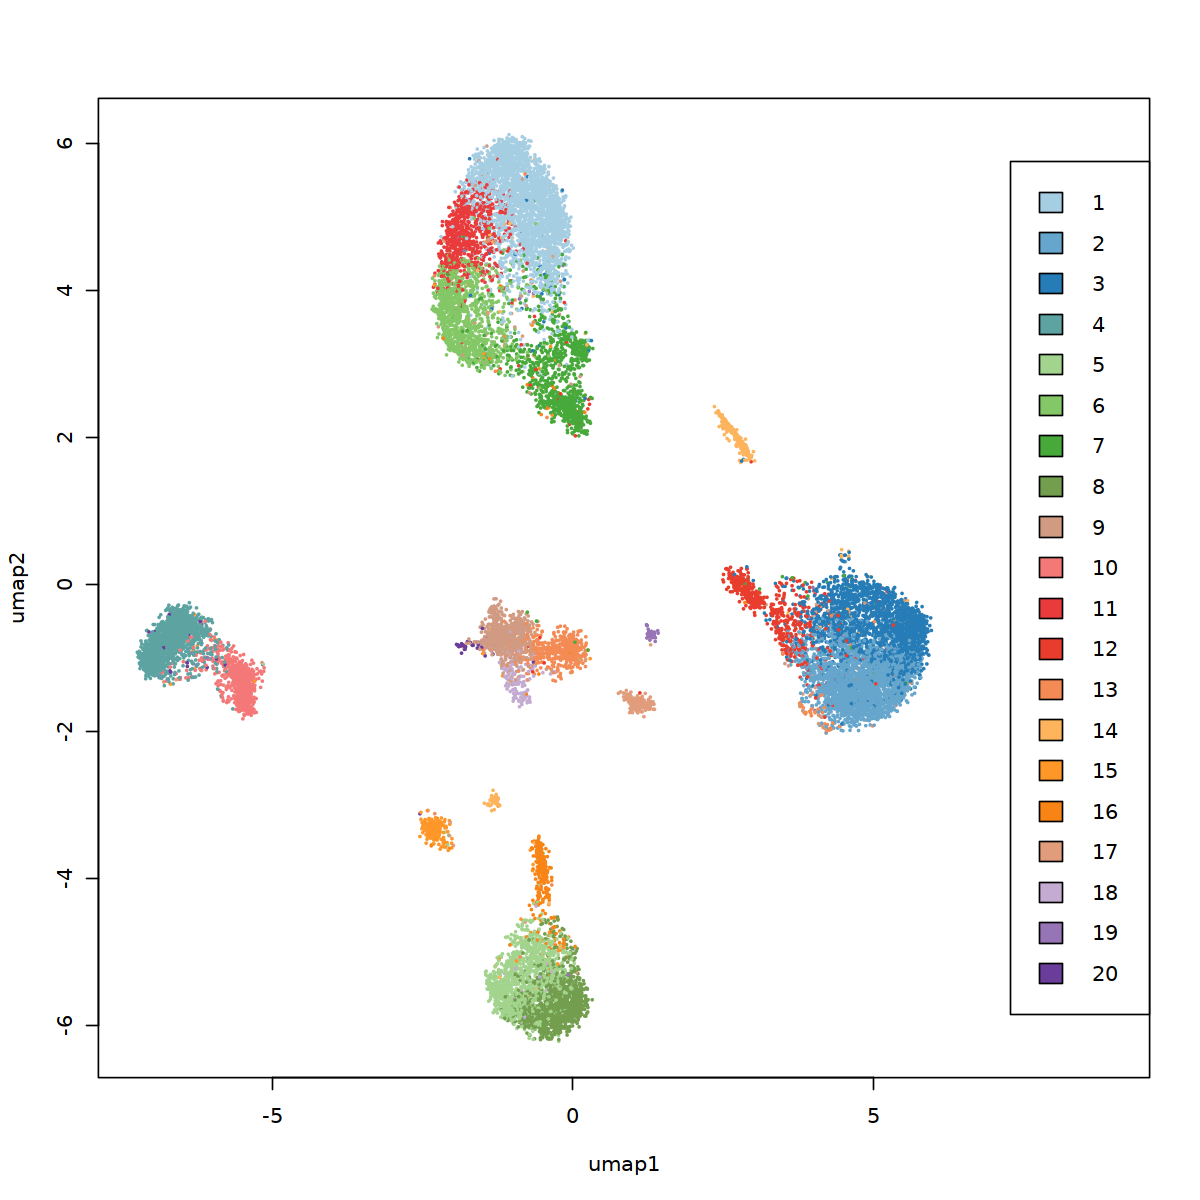

In [143]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

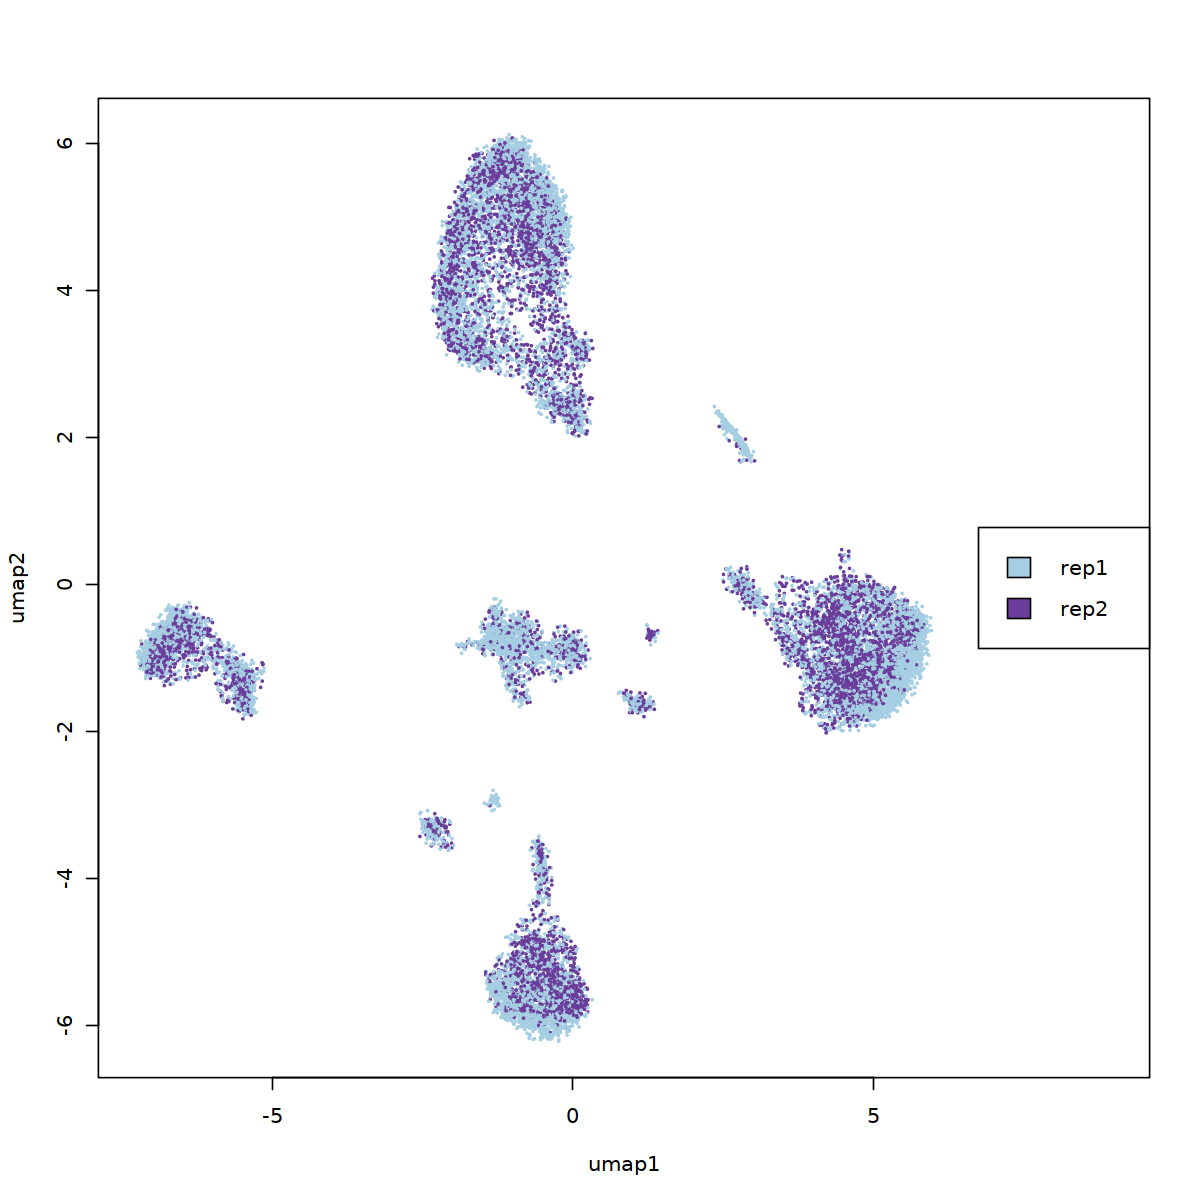

In [144]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [145]:
genotype_doublet_detection <- read_tsv("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_Mo17B73_P2_G031_10x.rep1.doublet_genotypes.txt", col_names = TRUE)  %>% 
    filter(final_cell_assignment == "Doublet")
sum(genotype_doublet_detection$cellID %in% tfidf.obj.dob.filt.clusters$Clusters$cellID)
remove_vector <- as.vector(genotype_doublet_detection$cellID)

Rows: 746 Columns: 37
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): cellID, BARCODE, DROPLET.TYPE, BEST.GUESS, NEXT.GUESS, SNG.BEST.GU...
dbl (26): total.x, tss.x, acrs.x, nSites.x, log10nSites.x, umap1, umap2, Lou...
lgl  (2): ptmt.x, ptmt.y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 5

In [146]:
remove_cell_IDs <- function(obj, cell_ID_names_rm) { 

    old_meta <- obj$Clusters
    
    new_meta <- old_meta[!old_meta$cellID %in% cell_ID_names_rm, ] 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

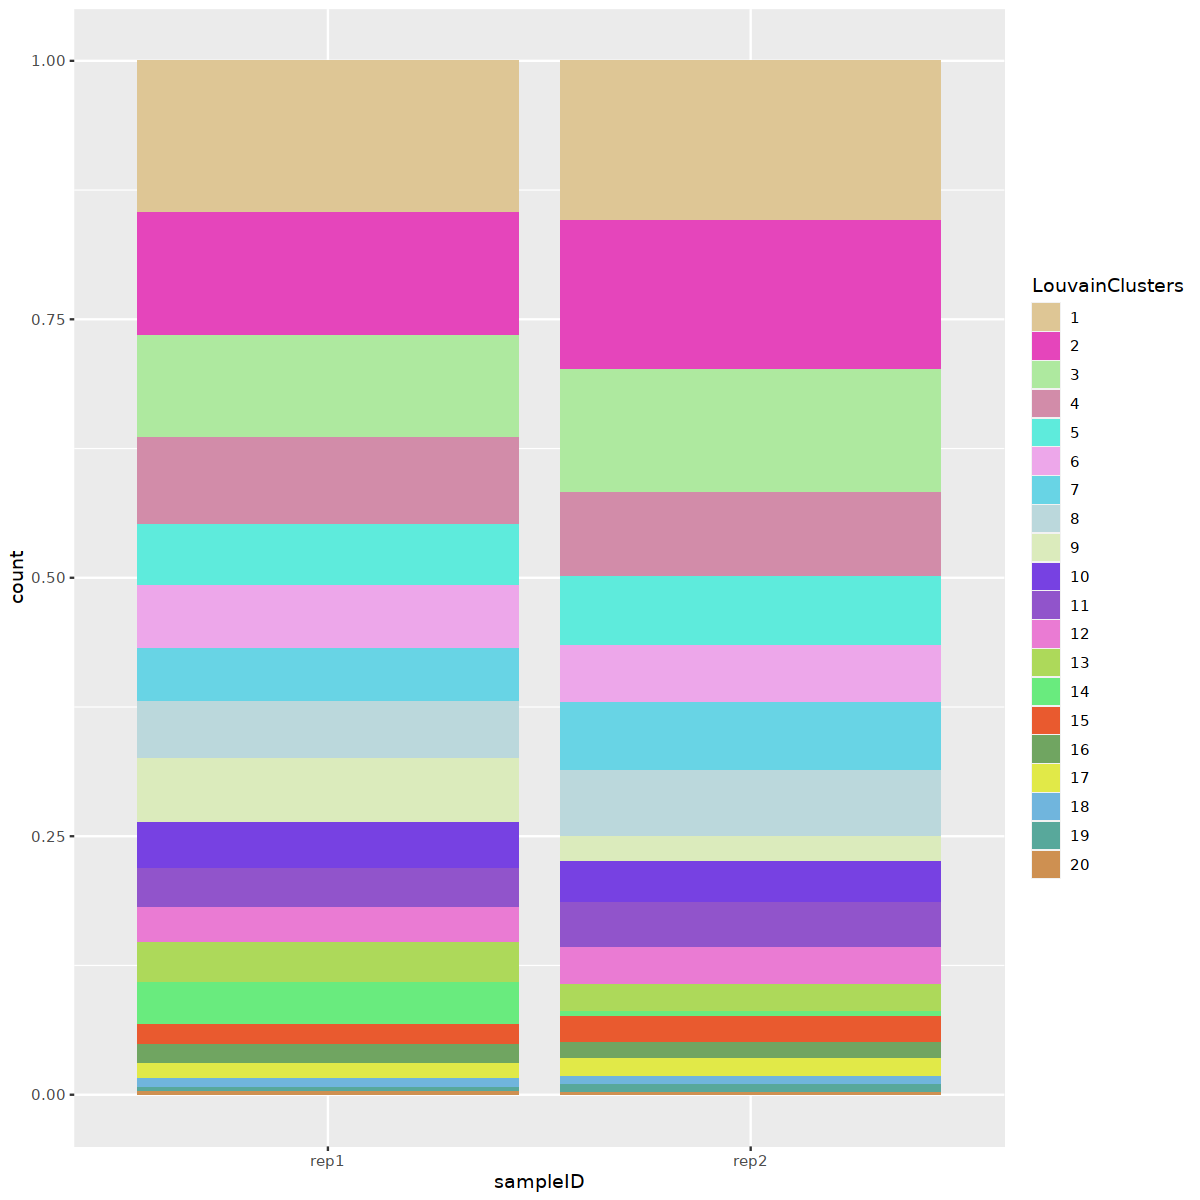

In [147]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [148]:
final_removed_genotype_doublets <- remove_cell_IDs(tfidf.obj.dob.filt.clusters,remove_vector)

   * Doublet filtering * Number cells removed= 5  Filtered: cells = 19213 | peaks = 70487



In [149]:
str(cell_converted_trible)

tibble [19,218 × 24] (S3: tbl_df/tbl/data.frame)
 $ cellID         : chr [1:19218] "BC:Z:GTGAAAGGCTACAAACAATGAGCTCGGA-Zm_rep1_P4_10x.rep1" "BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1" "BC:Z:GTTTCGATGTCAAGCGAGTCCGCACCGG-Zm_rep1_P6_10x.rep1" "BC:Z:GAGTGGAGTTCCAGCGAGTCCGCACTAA-Zm_rep1_P8_10x.rep1" ...
 $ total          : num [1:19218] 175951 131016 81977 76035 69248 ...
 $ tss            : num [1:19218] 26318 30764 11518 10459 3883 ...
 $ acrs           : num [1:19218] 26888 44240 13790 10258 1797 ...
 $ ptmt           : num [1:19218] 3467 661 308 3856 45 ...
 $ nSites         : num [1:19218] 122915 87503 56566 53253 49831 ...
 $ log10nSites    : num [1:19218] 5.09 4.94 4.75 4.73 4.7 ...
 $ pTSS           : num [1:19218] 0.1496 0.2348 0.1405 0.1376 0.0561 ...
 $ FRiP           : num [1:19218] 0.153 0.338 0.168 0.135 0.026 ...
 $ pOrg           : num [1:19218] 0.0197 0.00505 0.00376 0.05071 0.00065 ...
 $ tss_z          : num [1:19218] -0.585 -0.298 -0.615 -0.625 -0.9 ...
 $ acr

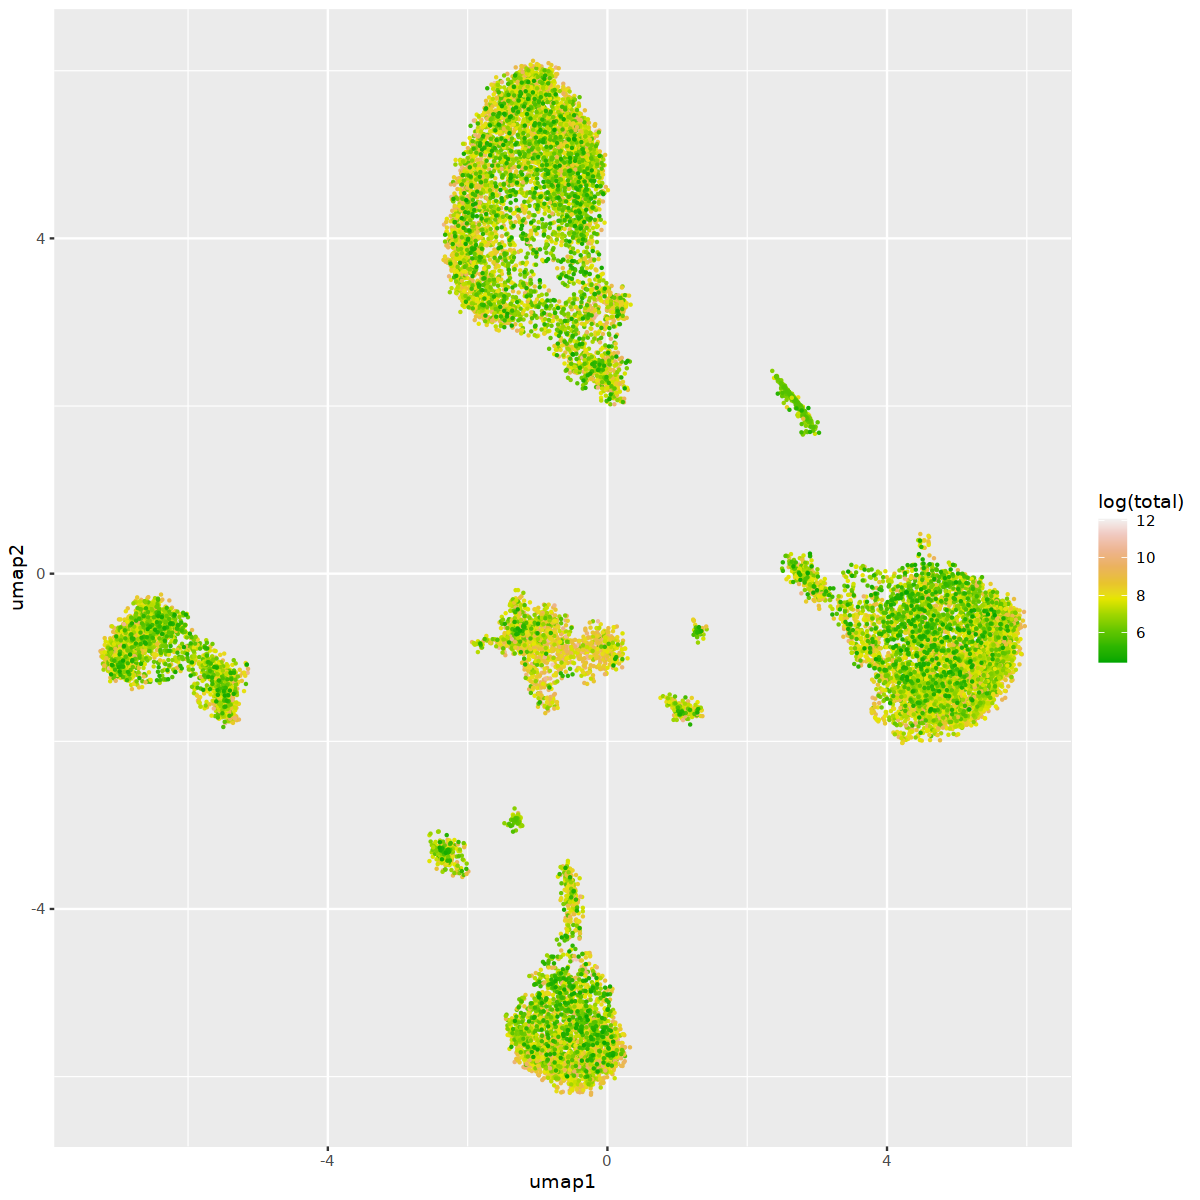

In [150]:
ggplot(cell_converted_trible ,aes(x = umap1, y=umap2, colour= log(total))) + 
    geom_point(size = .2) + scale_colour_gradientn(colours = terrain.colors(10))

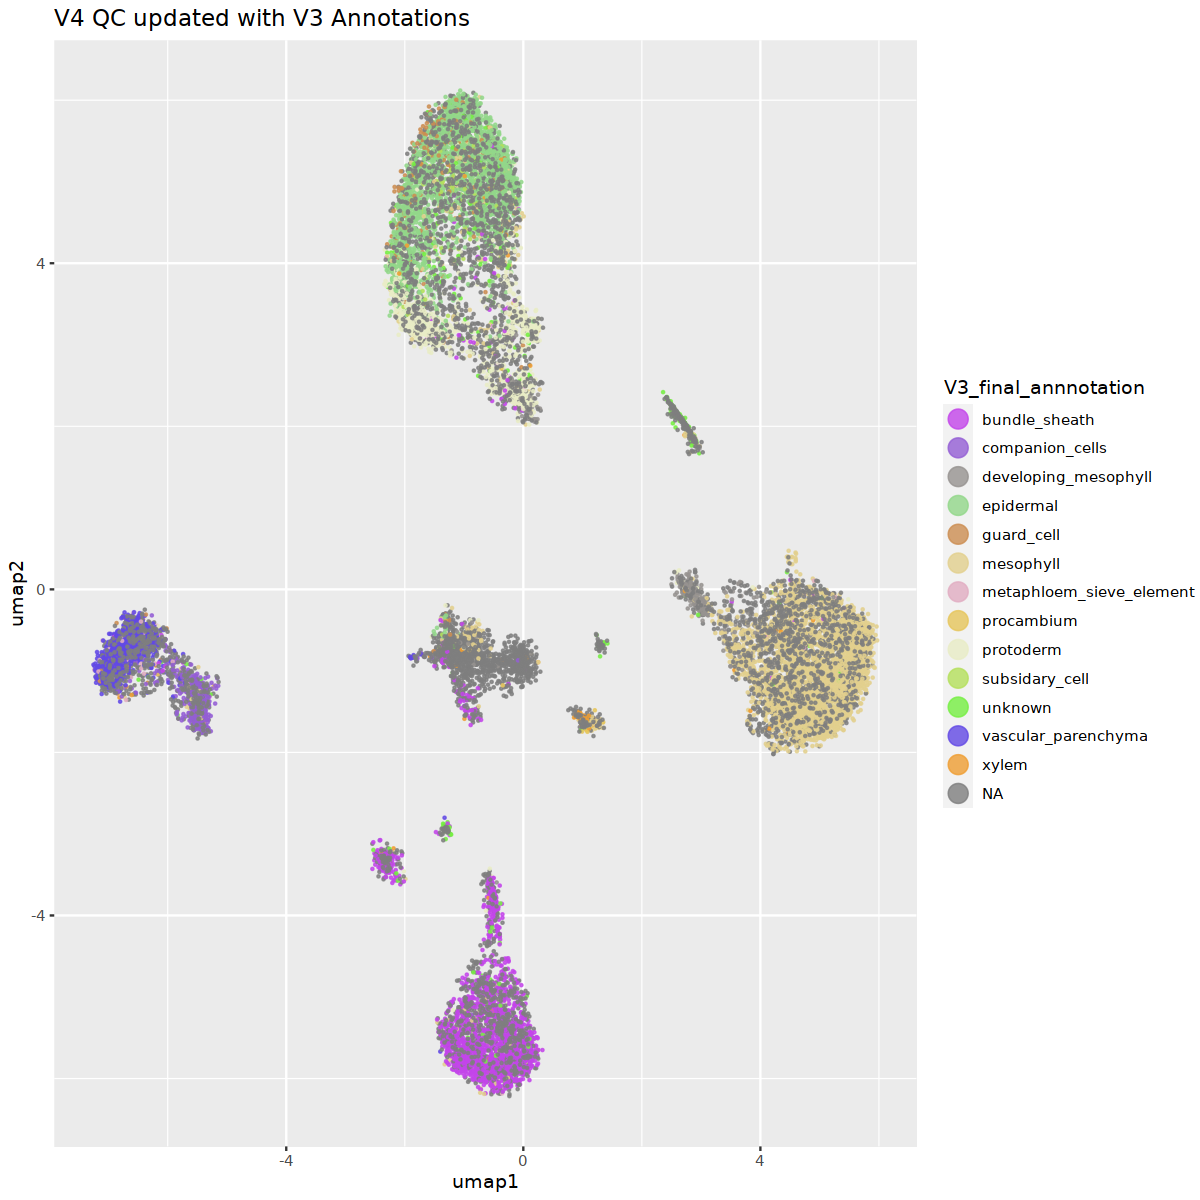

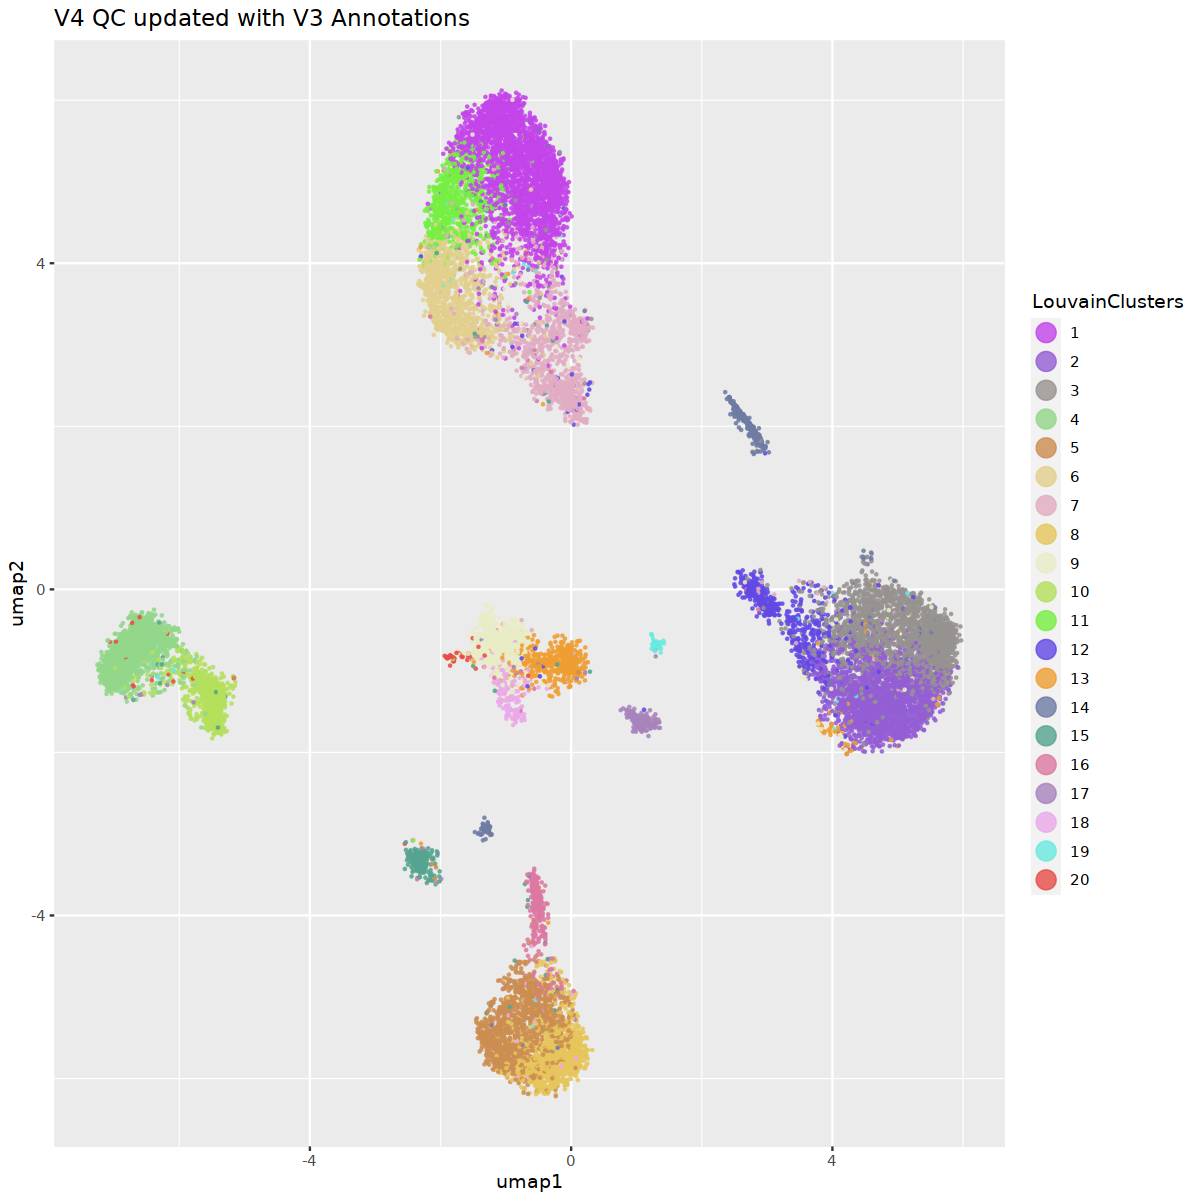

In [151]:
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)

## Compare this to old annotation
zm_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Zm_leaf.V3_final.txt"
zm_meta_data <- read.delim(zm_meta)  %>% 
    select(cellID, V3_final_annnotation)


merged.v3.v4_meta <- left_join(cell_converted_trible, zm_meta_data, by = "cellID") 

ggplot(merged.v3.v4_meta ,aes(x = umap1, y=umap2, colour= V3_final_annnotation)) + 
    scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
     geom_point(size = .25, alpha = .8) + ggtitle("V4 QC updated with V3 Annotations")


ggplot(merged.v3.v4_meta ,aes(x = umap1, y=umap2, colour= LouvainClusters)) + 
    scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
     geom_point(size = .25, alpha = .8) + ggtitle("V4 QC updated with V3 Annotations")


In [152]:
colnames(merged.v3.v4_meta)

[1] "cellID"               "total"                "tss"                 
 [4] "acrs"                 "ptmt"                 "nSites"              
 [7] "log10nSites"          "pTSS"                 "FRiP"                
[10] "pOrg"                 "tss_z"                "acr_z"               
[13] "sites_z"              "qc_check"             "background"          
[16] "cellbulk"             "is_cell"              "sampleID"            
[19] "umap1"                "umap2"                "doubletscore"        
[22] "d.type"               "ptmt_ratio"           "LouvainClusters"     
[25] "V3_final_annnotation"

In [153]:
library(patchwork)

log_10_sites <- ggplot(merged.v3.v4_meta ,aes(x = LouvainClusters, y=log10nSites, colour= LouvainClusters)) + 
    scale_colour_manual(values=other) + guides(colour = guide_legend(override.aes = list(size=2))) + 
     geom_violin() + geom_boxplot(width = .1) + facet_grid(sampleID~.) + ggtitle("V4 QC updated with V3 Annotations") + 
    theme(legend.position = "none")


In [154]:
ptmt_ratio <- ggplot(merged.v3.v4_meta ,aes(x = LouvainClusters, y=(ptmt/total), colour= LouvainClusters)) + 
    scale_colour_manual(values=other) + guides(colour = guide_legend(override.aes = list(size=2))) + 
     geom_violin() + geom_boxplot(width = .1) + facet_grid(sampleID~.) + ggtitle("V4 QC updated with V3 Annotations") + theme(legend.position = "none")


In [155]:
total_tn5_sites <- ggplot(merged.v3.v4_meta ,aes(x = LouvainClusters, y=log(total), colour= LouvainClusters)) + 
    scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
     geom_violin() + geom_boxplot(width = .1) + facet_grid(sampleID~.) + ggtitle("V4 QC updated with V3 Annotations")


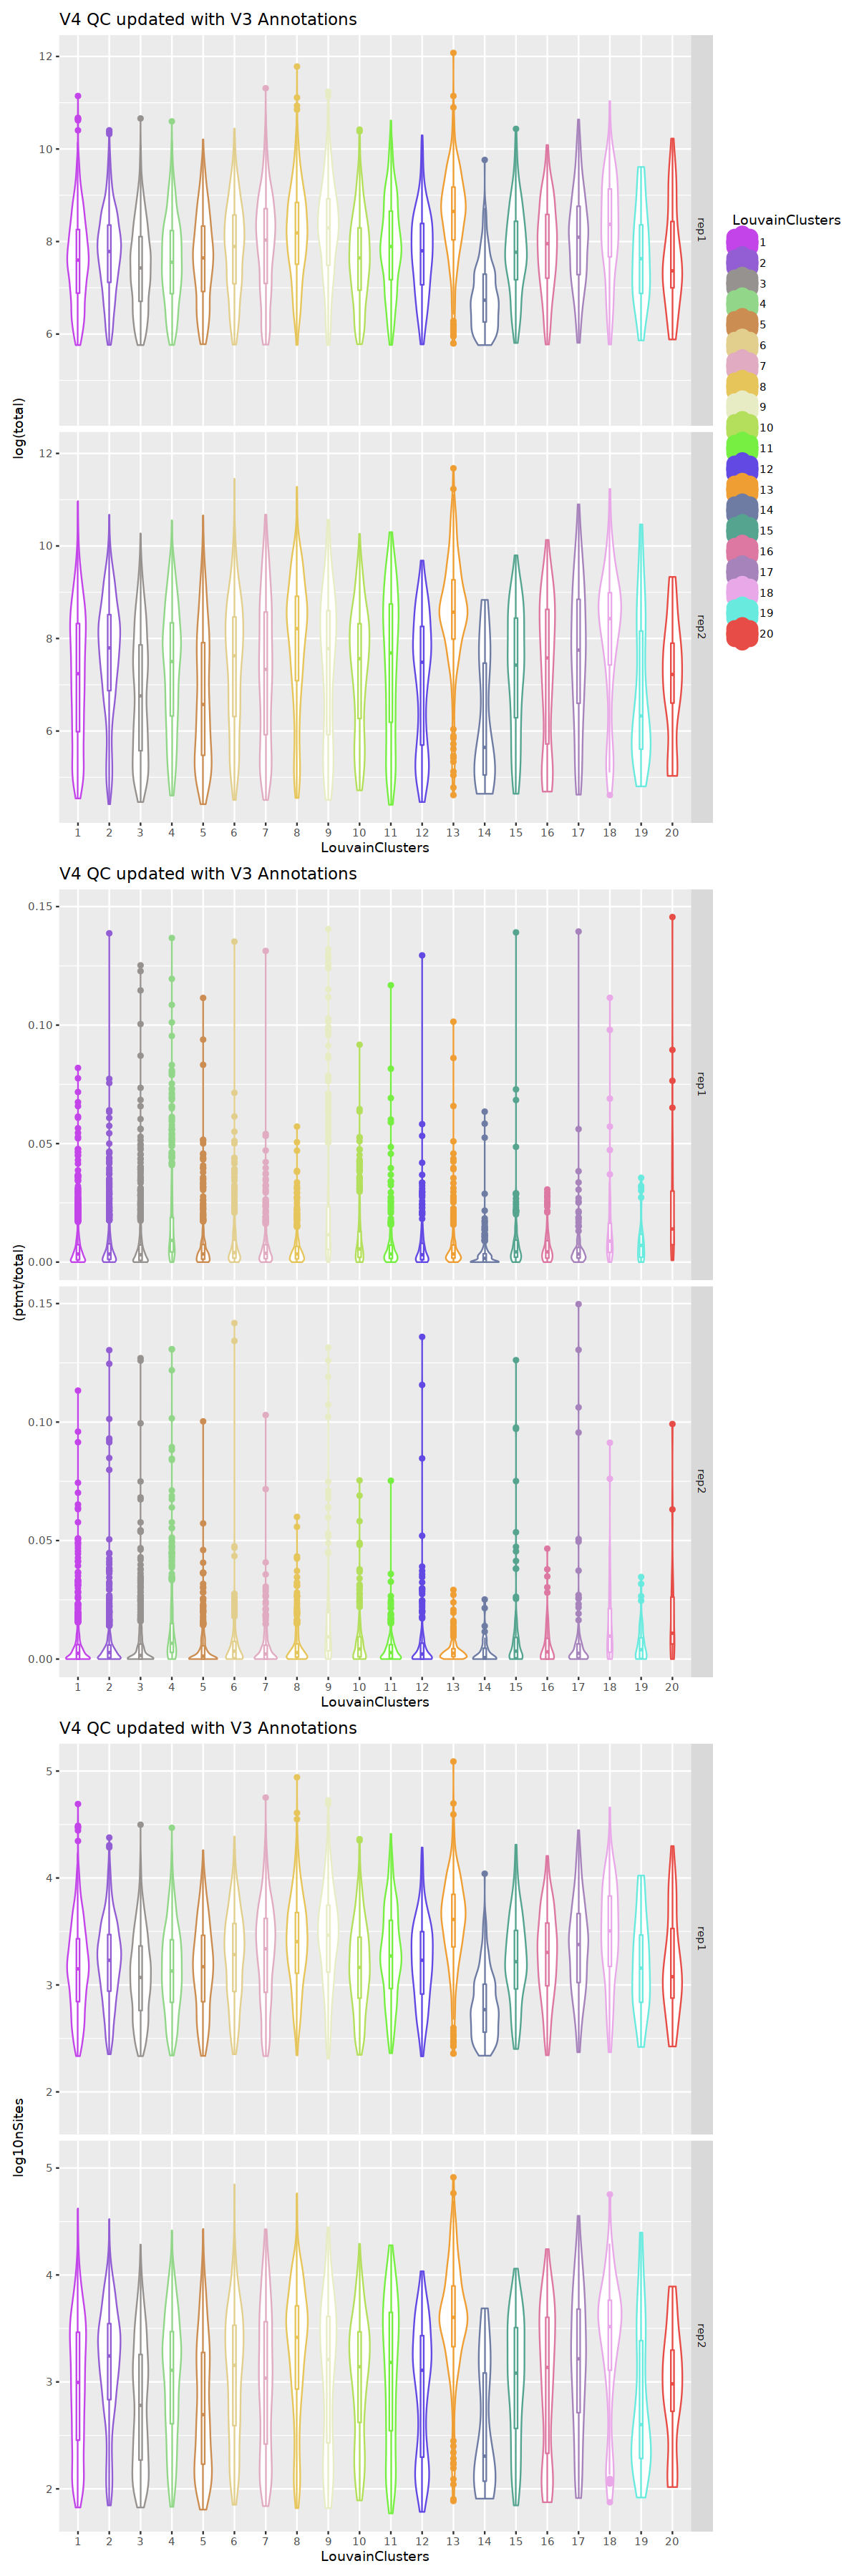

In [156]:
options(repr.plot.width=10, repr.plot.height=30)
total_tn5_sites/ptmt_ratio/log_10_sites

In [157]:

prefix <- "Zm_leaf.updated_QC_2.annot.V4"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/"
paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_outputZm_leaf.updated_QC_2.annot.V4.merged_clusters.sparse"

In [158]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [159]:
saveRDS(tfidf.obj.dob.filt.clusters, file=paste0(output_location, prefix, ".soc_obj.rds"))

# Run Presto on Louvain Clusters

In [33]:
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}


run_presto_specific_test <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)

    
    return(list(UIMatrix, garbbed_louv_order))
}

In [3]:

tfidf.obj.dob.filt.clusters <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/Zm_leaf.updated_QC_2.annot.V4.soc_obj.rds")

In [4]:
setwd("/scratch/jpm73279/comparative_single_cell/dev_location")
tfidf.obj.dob.filt.clusters$all_genes <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM_Zm00001eb.1.genes.bed"
bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0.fa.fai"

In [5]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
tfidf.obj.dob.filt.clusters.counts <- tfidf.obj.dob.filt.clusters
tfidf.obj.dob.filt.clusters.counts$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/Zm.gene_counts.output"

In [14]:
colnames(tfidf.obj.dob.filt.clusters.counts$Clusters)

[1] "cellID"          "total"           "tss"             "acrs"           
 [5] "ptmt"            "nSites"          "log10nSites"     "pTSS"           
 [9] "FRiP"            "pOrg"            "tss_z"           "acr_z"          
[13] "sites_z"         "qc_check"        "background"      "cellbulk"       
[17] "is_cell"         "sampleID"        "umap1"           "umap2"          
[21] "doubletscore"    "d.type"          "ptmt_ratio"      "LouvainClusters"

In [15]:
## Execute Annotation Attempt #1

library(presto)
library(tidyverse)
tfidf.obj.dob.filt.clusters.counts.final <- run_presto(tfidf.obj.dob.filt.clusters.counts,
           meta_slot = "Clusters",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 24
  cellID     total   tss  acrs  ptmt nSites log10…¹   pTSS   FRiP    pOrg  tss_z
  <chr>      <dbl> <dbl> <dbl> <dbl>  <dbl>   <dbl>  <dbl>  <dbl>   <dbl>  <dbl>
1 BC:Z:GTG… 175951 26318 26888  3467 122915    5.09 0.150  0.153  1.97e-2 -0.585
2 BC:Z:GTG… 131016 30764 44240   661  87503    4.94 0.235  0.338  5.05e-3 -0.298
3 BC:Z:GTT…  81977 11518 13790   308  56566    4.75 0.141  0.168  3.76e-3 -0.615
4 BC:Z:GAG…  76035 10459 10258  3856  53253    4.73 0.138  0.135  5.07e-2 -0.625
5 BC:Z:GTG…  69248  3883  1797    45  49831    4.70 0.0561 0.0260 6.50e-4 -0.900
6 BC:Z:GTG…  68731  7341  5026   646  49388    4.69 0.107  0.0731 9.40e-3 -0.729
# … with 13 more variables: acr_z <dbl>, sites_z <dbl>, qc_check <dbl>,
#   background <dbl>, cellbulk <dbl>, is_cell <dbl>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   ptmt_ratio <dbl>, LouvainClusters <fct>, and abbreviated variable name
#   ¹​log10nSites
# A tibble: 6 × 3
  gene_name      

In [26]:
marker_list_maize_file <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/markers/Zm.markers.leaf.txt"
marker_list_maize <- read_delim(marker_list_maize_file, delim='\t', 
                                       col_names = TRUE)

Rows: 188 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chr, geneID, name, type, tissue
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [27]:
head(marker_list_maize)

chr   start     end       geneID          name     
1 chr10  14827732  14830329 Zm00001eb408920 sweet13a 
2 chr10  14592719  14595578 Zm00001eb408900 sweet13b 
3 chr3   95886707  95888621 Zm00001eb133100 sweet13c 
4 chr6   42703954  42709741 Zm00001d035717  UmamiT21a
5 chr1  220494845 220500783 Zm00001eb041890 kan1     
6 chr6   77997391  77998399 Zm00001eb270060 BAF1     
  type                                    tissue                     
1 abaxial_bundle_sheath.phloem_parenchyma leaf                       
2 abaxial_bundle_sheath.phloem_parenchyma leaf                       
3 abaxial_bundle_sheath.phloem_parenchyma leaf                       
4 abaxial_bundle_sheath.phloem_parenchyma axillaryBud;leaf           
5 abaxial_domains                         leaf;tassel;ear;axillaryBud
6 axillary_meristem                       axillaryBud;leaf;tassel;ear

In [47]:
grabbed_top_marker_per_cluster <- top_markers(tfidf.obj.dob.filt.clusters.counts.final$presto_marker, 200)
represented_marker_lst <- list()
for (i in unique(tfidf.obj.dob.filt.clusters.counts.final$Clusters$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_maize, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

$`13`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`8`
# A tibble: 5 × 8
   rank geneID          chr       start       end name  type              tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr> <chr>             <chr> 
1     1 Zm00001eb121470 chr3    7184482   7190135 me3   bundle_sheath     axill…
2    15 Zm00001eb197410 chr4  196177320 196178190 ssu1  bundle_sheath     axill…
3    27 Zm00001eb041120 chr1  216343268 216349212 ccr1  bundle_sheath,va… axill…
4    31 Zm00001eb033390 chr1  185941269 185953288 dct2  bundle_sheath     axill…
5   100 Zm00001eb092540 chr2  147040782 147041974 ssu2  bundle_sheath     axill…

$`7`
# A tibble: 3 × 8
   rank geneID          chr       start       end name   type             tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr>  <chr>            <chr> 
1     1 Zm00001eb084940 chr2   66223855  66236990 ba2    axillary_merist… axill…
2    45 Zm00001eb050660 chr1  257907538 257913218 phb    xylem_parenchym… axill…
3   100 Zm00001eb223190 chr5   36008903  36017433 ZmNEN1 metaphloem_siev… axill…

$`9`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`1`
# A tibble: 2 × 8
   rank geneID          chr       start       end name  type              tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr> <chr>             <chr> 
1     4 Zm00001eb313510 chr7  123684235 123693464 gl1   epidermis         axill…
2    99 Zm00001eb171720 chr4   30910426  30916600 ocl5  protoderm,L1_SAM… axill…

$`18`
# A tibble: 2 × 8
   rank geneID          chr       start       end name  type          tissue    
  <int> <chr>           <chr>     <dbl>     <dbl> <chr> <chr>         <chr>     
1     2 Zm00001eb121470 chr3    7184482   7190135 me3   bundle_sheath axillaryB…
2   104 Zm00001eb197410 chr4  196177320 196178190 ssu1  bundle_sheath axillaryB…

$`3`
# A tibble: 6 × 8
   rank geneID          chr       start       end name   type             tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr>  <chr>            <chr> 
1     3 Zm00001eb158810 chr3  220987633 220994980 cah1   mesophyll        axill…
2     5 Zm00001eb383680 chr9   70927063  70932470 pepc1  mesophyll        axill…
3   112 Zm00001eb004320 chr1   12064978  12072983 nod    stomata          axill…
4   128 Zm00001eb067270 chr2    3630367   3636867 ZmMP_2 procambial_meri… axill…
5   147 Zm00001eb296990 chr6  178052132 178057800 agp2   pith_parenchyma  axill…
6   157 Zm00001eb038930 chr1  207808564 207812703 mdh6   mesophyll        axill…

$`4`
# A tibble: 4 × 8
   rank geneID          chr       start       end name   type             tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr>  <chr>            <chr> 
1     5 Zm00001eb005460 chr1   15196463  15201827 sut1   companion_cells… axill…
2    27 Zm00001eb233310 chr5   88320790  88324201 ZmAPL  protophloem_sie… axill…
3    77 Zm00001eb397900 chr9  146331757 146336666 ZmLRD3 protophloem_sie… axill…
4   174 Zm00001eb050790 chr1  258566321 258579264 bhlh43 bundle_sheath    axill…

$`17`
# A tibble: 4 × 8
   rank geneID          chr       start       end name    type            tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr>   <chr>           <chr> 
1     4 Zm00001eb046050 chr1  238442885 238446423 ad1     protoderm,L1_S… axill…
2    43 Zm00001eb344960 chr8   77541178  77544363 fama    guard_mother_c… axill…
3    89 Zm00001eb144140 chr3  169867979 169872110 te1     peripheral_zon… axill…
4    93 Zm00001eb243020 chr5  173207819 173211301 ZmSMXL5 protophloem_si… axill…

$`11`
# A tibble: 4 × 8
   rank geneID          chr       start       end name  type              tissue
  <int> <chr>           <chr>     <dbl>     <dbl> <chr> <chr>             <chr> 
1     3 Zm00001eb313510 chr7  123684235 123693464 gl1   epidermis         axill…
2    90 Zm00001eb319090 ch

In [50]:
combined_maize_v4_presto_results <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)

In [51]:
combined_maize_v4_presto_results

LouvainCluster rank geneID          chr   start     end       name    
1  1                4  Zm00001eb313510 chr7  123684235 123693464 gl1     
2  1               99  Zm00001eb171720 chr4   30910426  30916600 ocl5    
3  10               2  Zm00001eb005460 chr1   15196463  15201827 sut1    
4  10              15  Zm00001eb050790 chr1  258566321 258579264 bhlh43  
5  10              63  Zm00001eb402200 chr9  157693146 157697816 sut7    
6  11               3  Zm00001eb313510 chr7  123684235 123693464 gl1     
7  11              90  Zm00001eb319090 chr7  147881484 147888019 ocl3    
8  11              95  Zm00001eb126140 chr3   27678358  27686014 ocl1    
9  11             162  Zm00001eb336530 chr8   17391163  17395311 vt2     
10 12               4  Zm00001eb383680 chr9   70927063  70932470 pepc1   
11 12               7  Zm00001eb158810 chr3  220987633 220994980 cah1    
12 12              37  Zm00001eb359190 chr8  150377960 150388567 cah6    
13 12              67  Zm00001eb084940 chr2   66223855  66236990 ba2     
14 15              19  Zm00001eb041120 chr1  216343268 216349212 ccr1    
15 15             115  Zm00001eb408920 chr10  14827732  14830329 sweet13a
16 15             164  Zm00001eb336530 chr8   17391163  17395311 vt2     
17 15             169  Zm00001eb408900 chr10  14592719  14595578 sweet13b
18 15             180  Zm00001eb121470 chr3    7184482   7190135 me3     
19 16               2  Zm00001eb121470 chr3    7184482   7190135 me3     
20 16               6  Zm00001eb084940 chr2   66223855  66236990 ba2     
21 16               9  Zm00001eb033390 chr1  185941269 185953288 dct2    
22 16              15  Zm00001eb197410 chr4  196177320 196178190 ssu1    
23 16              73  Zm00001eb041120 chr1  216343268 216349212 ccr1    
24 16             190  Zm00001eb378150 chr9   25170886  25178773 nst1    
25 17               4  Zm00001eb046050 chr1  238442885 238446423 ad1     
26 17              43  Zm00001eb344960 chr8   77541178  77544363 fama    
27 17              89  Zm00001eb144140 chr3  169867979 169872110 te1     
28 17              93  Zm00001eb243020 chr5  173207819 173211301 ZmSMXL5 
29 18               2  Zm00001eb121470 chr3    7184482   7190135 me3     
30 18             104  Zm00001eb197410 chr4  196177320 196178190 ssu1    
31 2                3  Zm00001eb158810 chr3  220987633 220994980 cah1    
32 2                5  Zm00001eb383680 chr9   70927063  70932470 pepc1   
33 2               10  Zm00001eb359190 chr8  150377960 150388567 cah6    
34 2              160  Zm00001eb296990 chr6  178052132 178057800 agp2    
35 20              77  Zm00001eb383120 chr9   66110461  66115579 acl5    
36 3                3  Zm00001eb158810 chr3  220987633 220994980 cah1    
37 3                5  Zm00001eb383680 chr9   70927063  70932470 pepc1   
38 3              112  Zm00001eb004320 chr1   12064978  12072983 nod     
39 3              128  Zm00001eb067270 chr2    3630367   3636867 ZmMP_2  
40 3              147  Zm00001eb296990 chr6  178052132 178057800 agp2    
41 3              157  Zm00001eb038930 chr1  207808564 207812703 mdh6    
42 4                5  Zm00001eb005460 chr1   15196463  15201827 sut1    
43 4               27  Zm00001eb233310 chr5   88320790  88324201 ZmAPL   
44 4               77  Zm00001eb397900 chr9  146331757 146336666 ZmLRD3  
45 4              174  Zm00001eb050790 chr1  258566321 258579264 bhlh43  
46 5                4  Zm00001eb121470 chr3    7184482   7190135 me3     
47 5               10  Zm00001eb197410 chr4  196177320 196178190 ssu1    
48 5               22  Zm00001eb041120 chr1  216343268 216349212 ccr1    
49 5               37  Zm00001eb092540 chr2  147040782 147041974 ssu2    
50 5               48  Zm00001eb033390 chr1  185941269 185953288 dct2    
51 6                3  Zm00001eb313510 chr7  123684235 123693464 gl1     
52 6               30  Zm00001eb084940 chr2   66223855  66236990 ba2     
53 7                1  Zm00001eb084940 chr2   66223855  66236990 ba2     
54 7   

In [54]:
combined_maize_v4_presto_results  %>% 
    dplyr::select(LouvainCluster, name)  %>% 
    nest(name)  %>% 
    arrange()

Warning message:
"All elements of `...` must be named.
Did you want `data = name`?"


LouvainCluster data                                            
1  1              gl1 , ocl5                                      
2  10             sut1  , bhlh43, sut7                            
3  11             gl1 , ocl3, ocl1, vt2                           
4  12             pepc1, cah1 , cah6 , ba2                        
5  15             ccr1    , sweet13a, vt2     , sweet13b, me3     
6  16             me3 , ba2 , dct2, ssu1, ccr1, nst1              
7  17             ad1    , fama   , te1    , ZmSMXL5              
8  18             me3 , ssu1                                      
9  2              cah1 , pepc1, cah6 , agp2                       
10 20             acl5                                            
11 3              cah1  , pepc1 , nod   , ZmMP_2, agp2  , mdh6    
12 4              sut1  , ZmAPL , ZmLRD3, bhlh43                  
13 5              me3 , ssu1, ccr1, ssu2, dct2                    
14 6              gl1, ba2                                        
15 7              ba2   , phb   , ZmNEN1                          
16 8              me3 , ssu1, ccr1, dct2, ssu2